## 0. Table of Content


1. [프로젝트 소개](#1.-프로젝트-소개)  
   1.1 [프로젝트 배경](#1.1-프로젝트-배경)  
   1.2 [프로젝트 목적](#1.2-프로젝트-목적)   
2. [환경 세팅 및 데이터 업로드](#2.-환경-세팅-및-데이터-업로드)
3. [데이터 정제 및 전처리](#3.-데이터-정제-및-전처리)   
   3.1 [기초 재고 데이터](#3.1.-기초-재고-데이터)  
   3.2 [입고 재고 데이터](#3.2.-입고-재고-데이터)  
   3.3 [매출 데이터](#3.3.-매출-데이터)
5. [ABC 분석](#4.-ABC-분석)
6. [XYZ 분석](#5.-XYZ-분석)
7. [Dead Stock](#6.-Dead-Stock)
8. [Summary](#7.-Summary)

## 1. 프로젝트 소개

### 1.2 프로젝트 배경

이 프로젝트의 대상은 와인, 보드카, 위스키 등의 주류를 판매하는 소매 체인입니다.  
다양한 벤더로부터 완제품을 직접 구매하여 여러 매장에 분배하는 방식으로 운영되고 있습니다.  
제품 종류가 매우 다양하다 보니 제품별 수요 예측 및 재고 관리에 어려움이 따르고 있으며,  
이로 인해 불필요한 재고가 누적되고, 자본이 비효율적으로 묶이는 현상이 발생하고 있습니다.   
특히, 회전율이 낮은 제품들이 장기 재고로 남아 수익성 저하로 이어지는 문제가 있습니다.

### 1.3 프로젝트 목적

1) ABC 분석을 통해 제품별 수익 기여도를 파악하고, XYZ 분석을 통해 제품별 수요 변동성을 분석
2) 매장별 ABC·XYZ 결과를 기반으로 제품을 카테고리화하고, 카테고리별 맞춤형 재고 관리 전략 제안
3) 매장별 Dead Stock을 식별하여 불필요한 재고를 축소하고, 운영 효율성을 향상

## 2. 환경 세팅 및 데이터 업로드

In [1]:
#라이브러리 가져오기
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import style as style
import matplotlib.ticker as ticker
from matplotlib.patches import FancyBboxPatch
import os 
import numpy as np
import seaborn as sns 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [2]:
sns.set_theme(font_scale=1.0)
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "NanumGothic"
plt.rcParams["axes.unicode_minus"] = False
style.use("fivethirtyeight")

In [3]:
# font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
# font_path = f'C:\\Users\\annaz\\AppData\\Local\\Microsoft\\Windows\\Fonts\\MaruBuri-Regular.ttf'
# fontprop = fm.FontProperties(fname=font_path, size=20)
# plt.rc("font", family=fontprop.get_name())

In [4]:
os.getcwd()
os.chdir(r"C:\Users\annaz\projects\Inventory Optimization\warehouse-inventory-optimization\data\cleaned_data")
os.listdir()

['cleaned_endinv.csv',
 'cleaned_invoices.csv',
 'cleaned_productprice.csv',
 'cleaned_purchases.csv',
 'cleaned_sales.csv',
 'cleaned_srtinv.csv',
 'data_for_viz.csv',
 'dead_stock.csv']

In [5]:
# 기초 재고 데이터셋 불러오기
srtinv = pd.read_csv(
    'cleaned_srtinv.csv',
    dtype={'Store': 'str', 'Brand': 'str'},
    parse_dates=['startDate']
)

# 기말 재고 데이터셋 불러오기
endinv = pd.read_csv(
    'cleaned_endinv.csv',
    dtype={'Store': 'str', 'Brand': 'str'},
    parse_dates=['endDate']
)

# 공급업체로부터 제품 매입 기록 데이터셋 불러오기
purchases = pd.read_csv(
    'cleaned_purchases.csv',
    dtype={'Brand': 'str', 'Store': 'str', 'VendorNumber': 'str', 'PONumber': 'str'},
    parse_dates=['PODate', 'ReceivingDate', 'InvoiceDate', 'PayDate']
)

# 매출 데이터셋 불러오기
sales = pd.read_csv(
    'cleaned_sales.csv',
    dtype={'Brand': 'str', 'Store': 'str', 'VendorNo': 'str'},
    parse_dates=['SalesDate']
)

> 이 프로젝트에 사용하는 데이터셋은 앞서 클리닝된 데이터이므로 바로 사용 가능합니다.  
> 링크

In [6]:
dataframes = [srtinv, endinv, purchases, sales]

for df in dataframes: 
    df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206529 entries, 0 to 206528
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InventoryId  206529 non-null  object        
 1   Store        206529 non-null  object        
 2   City         206529 non-null  object        
 3   Brand        206529 non-null  object        
 4   Description  206529 non-null  object        
 5   Size         206529 non-null  object        
 6   onHand       206529 non-null  int64         
 7   Price        206529 non-null  float64       
 8   startDate    206529 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224489 entries, 0 to 224488
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InventoryId  224489 non-null  object       

In [7]:
purchases.shape

(2372474, 16)

In [8]:
sales.shape

(12825363, 14)

## 3. 데이터 정제 및 전처리

> ABC 분석을 수익 기준으로 진행할 계획입니다.  
> 현재 데이터셋에는  수익 값이 없으므로, 먼저 `Purchases` 데이터와 `srtinv` 데이터를 통합하여 지난 1년간 재고 제품의 매입가를 정리합니다.  
> 이후 이를 `Sales` 데이터와 병합하여, 각 제품의 수익률(판매가 대비 원가 비율)을 계산합니다.

### 3.1. 기초 재고 데이터

In [9]:
srtinv.head()

,InventoryId,Store,City,Brand,Description,Size,onHand,Price,startDate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,8,12.99,2016-01-01
1,1_HARDERSFIELD_60,1,HARDERSFIELD,60,Canadian Club 1858 VAP,750mL,7,10.99,2016-01-01
2,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,6,36.99,2016-01-01
3,1_HARDERSFIELD_63,1,HARDERSFIELD,63,Herradura Reposado Tequila,750mL,3,38.99,2016-01-01
4,1_HARDERSFIELD_72,1,HARDERSFIELD,72,No. 3 London Dry Gin,750mL,6,34.99,2016-01-01


Text(0.7, 21.99, 'Q3: 21.99')

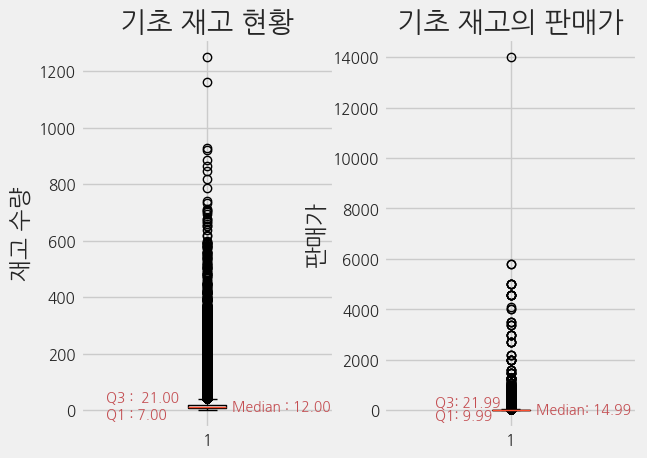

In [10]:
fig, axs = plt.subplots(1,2)

axs[0].boxplot(srtinv.onHand)
axs[0].set_title("기초 재고 현황")
axs[0].set_ylabel('재고 수량')

q1 = np.percentile(srtinv.onHand, 25)
median = np.median(srtinv.onHand)
q3 = np.percentile(srtinv.onHand, 75)

axs[0].text(1.1, median, f'Median : {median:.2f}', va = 'center', color = 'r', size = 10)
axs[0].text(0.6, q1, f'Q1 : {q1:.2f}', va = 'top', color = 'r', size = 10)
axs[0].text(0.6, q3, f'Q3 : {q3: .2f}', va = 'bottom', color = 'r', size = 10)


axs[1].boxplot(srtinv.Price)
axs[1].set_title("기초 재고의 판매가")
axs[1].set_ylabel('판매가')

q1_p = np.percentile(srtinv.Price, 25)
median_p = np.median(srtinv.Price)
q3_p = np.percentile(srtinv.Price, 75)

axs[1].text(1.1, median_p, f'Median: {median_p:.2f}', va = 'center', color = 'r', size = 10)
axs[1].text(0.7, q1_p, f'Q1: {q1_p:.2f}', va = 'top', color = 'r', size = 10)
axs[1].text(0.7, q3_p, f'Q3: {q3_p:.2f}', va = 'bottom', color = 'r', size = 10)


> 기초 재고는 대부분 한 매장에서 제품별 7~21개 수준으로 나타납니다.  
> 일부 제품은 특정 매장에서 재고가 과도하게 쌓여 있는 것으로 보입니다.  
> 제품 판매가의 중앙값은 15달러 미만이지만, 이상치가 존재합니다.  
> 해당 고가 제품에 대해서는 별도의 확인이 필요합니다. (추후 ABC 및 XYZ 분류 결과를 통해 확인 예정)  

In [11]:
#수량은 1000 개 보다 큰 제품 
srtinv[srtinv['onHand'] > 1000]

,InventoryId,Store,City,Brand,Description,Size,onHand,Price,startDate
173397,69_MOUNTMEND_3858,69,MOUNTMEND,3858,Grey Goose Vodka,750mL,1251,23.99,2016-01-01
204102,79_BALLYMENA_3859,79,BALLYMENA,3859,Smirnoff 80 Proof,375mL,1163,8.99,2016-01-01


In [12]:
#가격이 가장 높은 제품
srtinv[srtinv['Price']== srtinv['Price'].max()]

,InventoryId,Store,City,Brand,Description,Size,onHand,Price,startDate
78941,34_PITMERDEN_2693,34,PITMERDEN,2693,Glen Grant 50 Yr Scotch,750mL,1,13999.9,2016-01-01


In [13]:
#이상치 계산

def outliers (df, column):
    q1 = np.percentile(srtinv[column], 25)
    q3 = np.percentile(srtinv[column], 75)
    iqr = (q3 - q1) *1.5

    outliers = df[(df[column] >= (q3 + iqr)) | (df[column] <= (q1 - iqr))]

    return outliers

In [14]:
srtinv_price_outliers = outliers (srtinv, 'Price')
srtinv_onHand_outliers = outliers (srtinv, 'onHand')

In [15]:
srtinv_price_outliers.head()

,InventoryId,Store,City,Brand,Description,Size,onHand,Price,startDate
12,1_HARDERSFIELD_171,1,HARDERSFIELD,171,Gentleman Jack,1.75L,12,49.99,2016-01-01
13,1_HARDERSFIELD_175,1,HARDERSFIELD,175,1800 Anejo Tequila,750mL,6,41.99,2016-01-01
17,1_HARDERSFIELD_233,1,HARDERSFIELD,233,Tullamore Dew 12 Yr Old,750mL,11,42.99,2016-01-01
18,1_HARDERSFIELD_247,1,HARDERSFIELD,247,Gran Patron Platinum Tequil,750mL,1,199.99,2016-01-01
23,1_HARDERSFIELD_283,1,HARDERSFIELD,283,Milagro Tequila Reposado SBR,750mL,4,57.99,2016-01-01


[Text(0, 0, 'Grey Goose Vodka'),
 Text(0, 0, 'Smirnoff 80 Proof'),
 Text(0, 0, 'Smirnoff 80 Proof'),
 Text(0, 0, 'Smirnoff Watermelon'),
 Text(0, 0, 'Jack Daniels No 7 Black')]

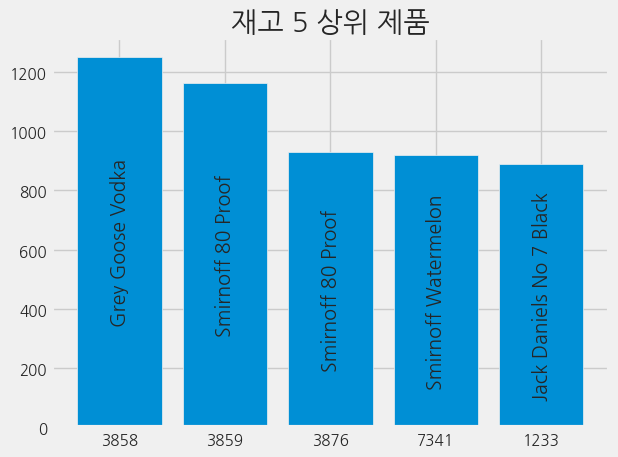

In [16]:
top_5 = srtinv.sort_values(by = 'onHand', ascending = False).head(5)
fig, ax = plt.subplots()
bar_container = ax.bar(top_5.Brand, top_5.onHand)
ax.set(title = '재고 5 상위 제품')
ax.bar_label(bar_container, labels=top_5.Description,
             rotation=90,
             label_type='center')

Text(0, 0.5, '매장별 합계 수량')

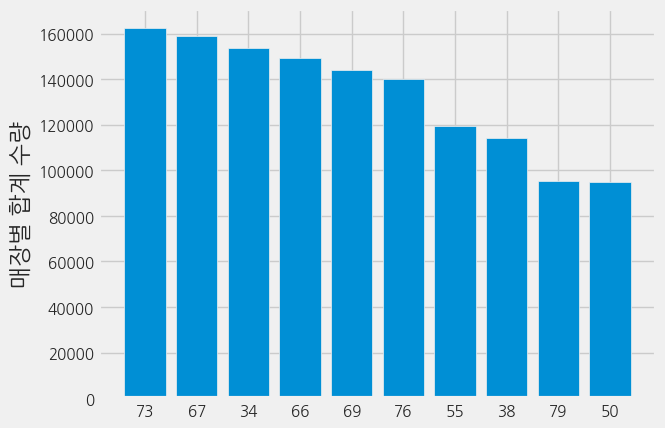

In [17]:
store_grouped = srtinv.groupby('Store')['onHand'].sum().reset_index()\
    .sort_values(by = 'onHand', ascending = False).head(10)
plt.bar(store_grouped['Store'], store_grouped['onHand'])
plt.ylabel('매장별 합계 수량')

[Text(0, 0, 'Capt Morgan Spiced Rum'),
 Text(0, 0, 'Absolut 80 Proof'),
 Text(0, 0, 'Smirnoff 80 Proof'),
 Text(0, 0, 'Ketel One Vodka'),
 Text(0, 0, "Maurice's Mentholated Mint"),
 Text(0, 0, 'Grey Goose Vodka'),
 Text(0, 0, 'Smirnoff 80 Proof'),
 Text(0, 0, 'Jack Daniels No 7 Black'),
 Text(0, 0, 'Bacardi Superior Rum'),
 Text(0, 0, 'Kendall Jackson Chard Vt RSV')]

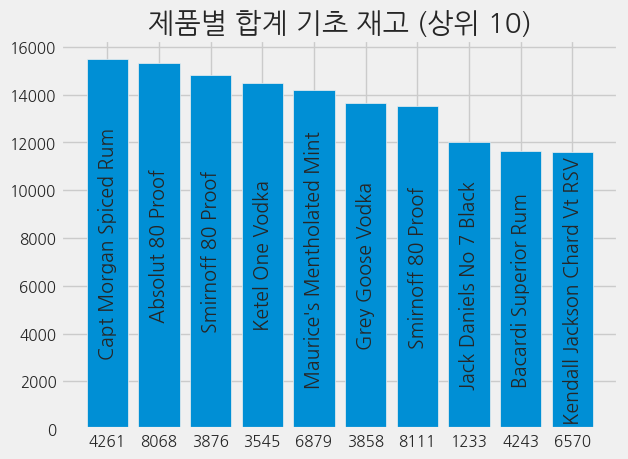

In [18]:
brand_grouped = srtinv.groupby('Brand').agg({'onHand': 'sum', 'Description':'first'})\
    .reset_index()\
    .sort_values(by = 'onHand', ascending = False).head(10)
fig, ax = plt.subplots()
bar_container = ax.bar(brand_grouped.Brand, brand_grouped.onHand)
ax.set(title = '제품별 합계 기초 재고 (상위 10)')
ax.bar_label(bar_container, labels=brand_grouped.Description,
             rotation=90,
             label_type='center')

> 기초 재고 데이터셋에서 필요한 열(Brand, Description, onHand)을 추출하고,  
> `onHand` 컬럼명을 `Quantity`로 변경  
> 수량이 0인 제품은 제외  
> Brand와 Description 기준으로 그룹화하여 총 수량(Quantity) 합계를 계산

In [19]:
start_stock = srtinv[['Brand', 'Description', 'onHand']]
start_stock = start_stock.rename(columns = {'onHand' : 'Quantity'})
start_stock = start_stock[start_stock['Quantity'] != 0].copy()
start_stock_grouped = start_stock.groupby(['Brand', 'Description']).agg({'Quantity' : 'sum'}).reset_index()

In [20]:
start_stock_grouped.sort_values(by = 'Quantity', ascending = False)

,Brand,Description,Quantity
6106,4261,Capt Morgan Spiced Rum,15499
7532,8068,Absolut 80 Proof,15341
5616,3876,Smirnoff 80 Proof,14829
5116,3545,Ketel One Vodka,14499
7324,6879,Maurice's Mentholated Mint,14180
...,...,...,...
6069,42333,Borgo M Fruili Pnt Grigio,1
1987,19768,B & G CDP Rose,1
7183,6389,Carlo Rossi Blush Calif,1
7085,6063,Avion Espresso,1


### 3.2. 입고 재고 데이터

In [21]:
purchases.head()

,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification
0,69_MOUNTMEND_8412,69,8412,Tequila Ocho Plata Fresno,750mL,105,ALTAMAR BRANDS LLC,8124,2015-12-21,2016-01-02,2016-01-04,2016-02-16,35.71,6,214.26,1
1,30_CULCHETH_5255,30,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-01,2016-01-07,2016-02-21,9.35,4,37.40,1
2,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-02,2016-01-07,2016-02-21,9.41,5,47.05,1
3,1_HARDERSFIELD_5255,1,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-01,2016-01-07,2016-02-21,9.35,6,56.10,1
4,76_DONCASTER_2034,76,2034,Glendalough Double Barrel,750mL,388,ATLANTIC IMPORTING COMPANY,8169,2015-12-24,2016-01-02,2016-01-09,2016-02-16,21.32,5,106.60,1


Text(0, 0.5, '매입된 수량(천 단위)')

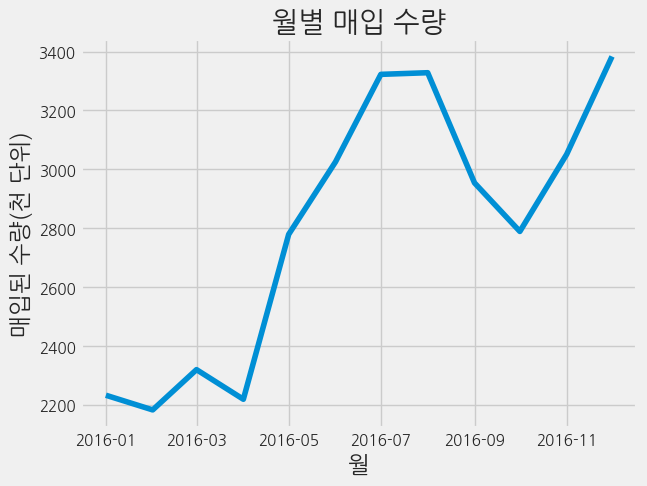

In [22]:
purchases['PurchasesMonth'] = purchases.ReceivingDate.dt.to_period('M')
purc_group_month = purchases.groupby('PurchasesMonth')['Quantity'].sum().div(1000).reset_index()
purc_group_month['PurchasesMonth'] = purc_group_month['PurchasesMonth'].dt.to_timestamp()
plt.plot(purc_group_month.PurchasesMonth, purc_group_month.Quantity)
plt.title('월별 매입 수량')
plt.xlabel('월')
plt.ylabel('매입된 수량(천 단위)')

Text(0.7, 5681.81, 'max: 5681.81')

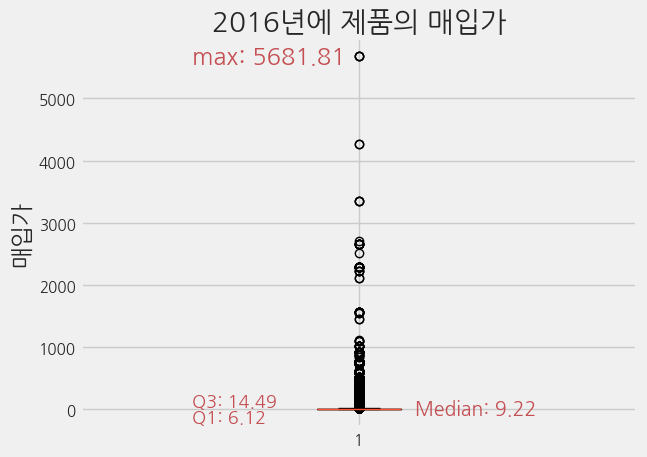

In [23]:
fig, axs = plt.subplots()

axs.boxplot(purchases.PurchasePrice)
axs.set_title("2016년에 제품의 매입가")
axs.set_ylabel('매입가')

q1_p = np.percentile(purchases.PurchasePrice, 25)
median_p = np.median(purchases.PurchasePrice)
q3_p = np.percentile(purchases.PurchasePrice, 75)
max_p = np.max(purchases.PurchasePrice)

axs.text(1.1, median_p, f'Median: {median_p:.2f}', va = 'center', color = 'r')
axs.text(0.7, q1_p, f'Q1: {q1_p:.2f}', va = 'top', color = 'r', fontsize = 13)
axs.text(0.7, q3_p, f'Q3: {q3_p:.2f}', va = 'bottom', color = 'r', fontsize = 13)
axs.text(0.7, max_p, f'max: {max_p:.2f}', va = 'center', color = 'r', fontsize = 17)

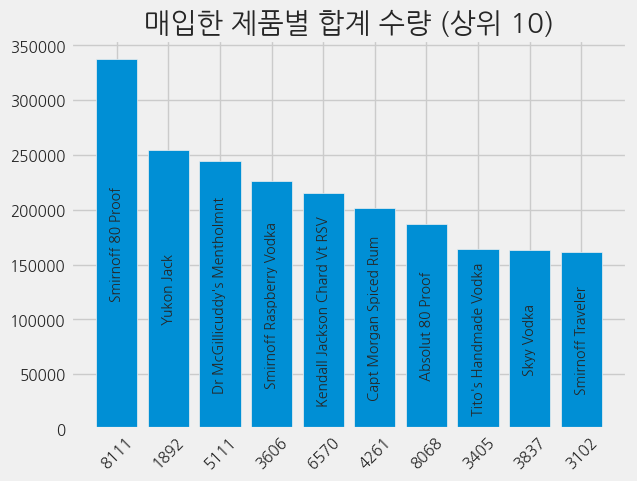

In [24]:
purc_brand_grouped = purchases.groupby('Brand')\
                .agg({'Quantity': 'sum',
                      'Description':'first'})\
    .reset_index().sort_values(by = 'Quantity', ascending =False).head(10)

fig, ax = plt.subplots()
bar_container = ax.bar(purc_brand_grouped.Brand, purc_brand_grouped.Quantity)
ax.set(title = '매입한 제품별 합계 수량 (상위 10)')
ax.bar_label(bar_container, labels=purc_brand_grouped.Description,
             rotation=90,
             label_type='center', fontsize = 10)
ax.tick_params(axis='x', rotation=45)

> 가장 많이 매입한 제품의 ABC 및 XYZ 카테고리를 확인할 필요가 있습니다.

> 구매 데이터(purchases)에서 분석에 필요한 열(Brand, Description, PurchasePrice, Quantity)만 추출

In [25]:
year_stock = purchases[['Brand', 'Description', 'PurchasePrice', 'Quantity']]

In [26]:
pd.set_option('display.max_rows', 153)
year_stock[year_stock['PurchasePrice']==0]

,Brand,Description,PurchasePrice,Quantity
1369009,2166,The Macallan Double Cask 12,0.0,12
1369018,2166,The Macallan Double Cask 12,0.0,12
1369031,2166,The Macallan Double Cask 12,0.0,12
1369032,2166,The Macallan Double Cask 12,0.0,12
1369033,2166,The Macallan Double Cask 12,0.0,12
1369043,2166,The Macallan Double Cask 12,0.0,12
1369045,2166,The Macallan Double Cask 12,0.0,12
1369058,2166,The Macallan Double Cask 12,0.0,12
1369060,2166,The Macallan Double Cask 12,0.0,12
1369063,2166,The Macallan Double Cask 12,0.0,12


> 벤더사 프로모션으로 뮤료로 받은 2166 제품 삭제

In [27]:
year_stock = year_stock[year_stock['PurchasePrice'] > 0]

In [28]:
year_stock.groupby('Brand')['PurchasePrice'].nunique().sort_values(ascending = False)

Brand
999      1
100      1
1000     1
10009    1
1001     1
        ..
1005     1
1004     1
10032    1
10030    1
1003     1
Name: PurchasePrice, Length: 10663, dtype: int64

> 1년간 매입한 제품들의 원가 변동은 없었습니다.

In [29]:
year_stock_grouped = year_stock.groupby(['Brand', 'Description'])\
    .agg({'PurchasePrice' : 'first', 'Quantity' : 'sum' }).reset_index()

In [30]:
year_stock_grouped

,Brand,Description,PurchasePrice,Quantity
0,100,Chivas Royal Salute,120.29,150
1,1000,Goslings Dark'n Stormy VAP,11.62,15
2,10009,Long Lake Cab Svgn Cal,4.13,48
3,1001,Bailey's 50mL 4 Pack,4.28,7177
4,10010,Long Lake Chard Cal,3.86,24
...,...,...,...,...
10658,994,Absolut Apeach,14.81,136
10659,995,Absolut Ruby Red,15.99,202
10660,996,Herradura Seleccion Suprema,222.21,27
10661,998,Corralejo Blanco Tequila,18.51,729


In [31]:
total_stock = year_stock_grouped.merge(start_stock_grouped, on='Brand', how = 'outer')

In [32]:
total_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11437 entries, 0 to 11436
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Brand          11437 non-null  object 
 1   Description_x  10663 non-null  object 
 2   PurchasePrice  10663 non-null  float64
 3   Quantity_x     10663 non-null  float64
 4   Description_y  8006 non-null   object 
 5   Quantity_y     8006 non-null   float64
dtypes: float64(3), object(3)
memory usage: 536.2+ KB


> 기초 재고 중 일부 제품은 해당 연도에 구매 기록이 없어 매입가를 확인할 수 없습니다.  
> 추후 구매 가격 값의 결측치를 채우기 위해, 매입가와 판매가 모두 기록되어 있는 제품들에 대한 마크업(markup)을 계산하여 평균 마크업률을 산출하여  
> 평균 마크업률을 기반으로 결측 구매가격을 추정하는 방식으로 결측치를 처리할 계획입니다.

In [33]:
total_stock[total_stock['PurchasePrice'].isna()]

,Brand,Description_x,PurchasePrice,Quantity_x,Description_y,Quantity_y
24,10126,NaN,NaN,NaN,Creta Olympias Vin Crete Red,12.0
25,10127,NaN,NaN,NaN,Creta Olympias Vin Crete Wh,27.0
93,1043,NaN,NaN,NaN,Jim Beam Gift Pak,1.0
96,10442,NaN,NaN,NaN,K Vntrs The Boy Grenache/Syr,12.0
112,105,NaN,NaN,NaN,Mr Boston Butterscotch,10.0
...,...,...,...,...,...,...
11405,953,NaN,NaN,NaN,Briottet Creme de Framboise,21.0
11410,961,NaN,NaN,NaN,Maschio Prime Arance,4.0
11413,97,NaN,NaN,NaN,Smirnoff Passion Fruit Vodka,44.0
11424,98,NaN,NaN,NaN,Smirnoff Grape Vodka,10.0


In [34]:
total_stock[['Quantity_x', 'Quantity_y']] = total_stock[['Quantity_x', 'Quantity_y']].fillna(0)
total_stock['Quantity'] = total_stock['Quantity_x'] + total_stock['Quantity_y']
total_stock = total_stock.drop(columns = ['Quantity_x', 'Quantity_y'])
total_stock['Description'] = total_stock['Description_x'].fillna(total_stock['Description_y'])
total_stock = total_stock.drop(columns=['Description_x', 'Description_y'])
total_stock

,Brand,PurchasePrice,Quantity,Description
0,100,120.29,183.0,Chivas Royal Salute
1,1000,11.62,62.0,Goslings Dark'n Stormy VAP
2,10009,4.13,48.0,Long Lake Cab Svgn Cal
3,1001,4.28,8352.0,Bailey's 50mL 4 Pack
4,10010,3.86,24.0,Long Lake Chard Cal
...,...,...,...,...
11432,994,14.81,149.0,Absolut Apeach
11433,995,15.99,217.0,Absolut Ruby Red
11434,996,222.21,42.0,Herradura Seleccion Suprema
11435,998,18.51,832.0,Corralejo Blanco Tequila


### 3.3. 매출 데이터

In [35]:
sales.head()

,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName
0,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2016-01-01,750.0,1,0.79,12546,JIM BEAM BRANDS COMPANY
1,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,2,32.98,16.49,2016-01-02,750.0,1,1.57,12546,JIM BEAM BRANDS COMPANY
2,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2016-01-03,750.0,1,0.79,12546,JIM BEAM BRANDS COMPANY
3,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,14.49,14.49,2016-01-08,750.0,1,0.79,12546,JIM BEAM BRANDS COMPANY
4,1_HARDERSFIELD_1005,1,1005,Maker's Mark Combo Pack,375mL 2 Pk,2,69.98,34.99,2016-01-09,375.0,1,0.79,12546,JIM BEAM BRANDS COMPANY


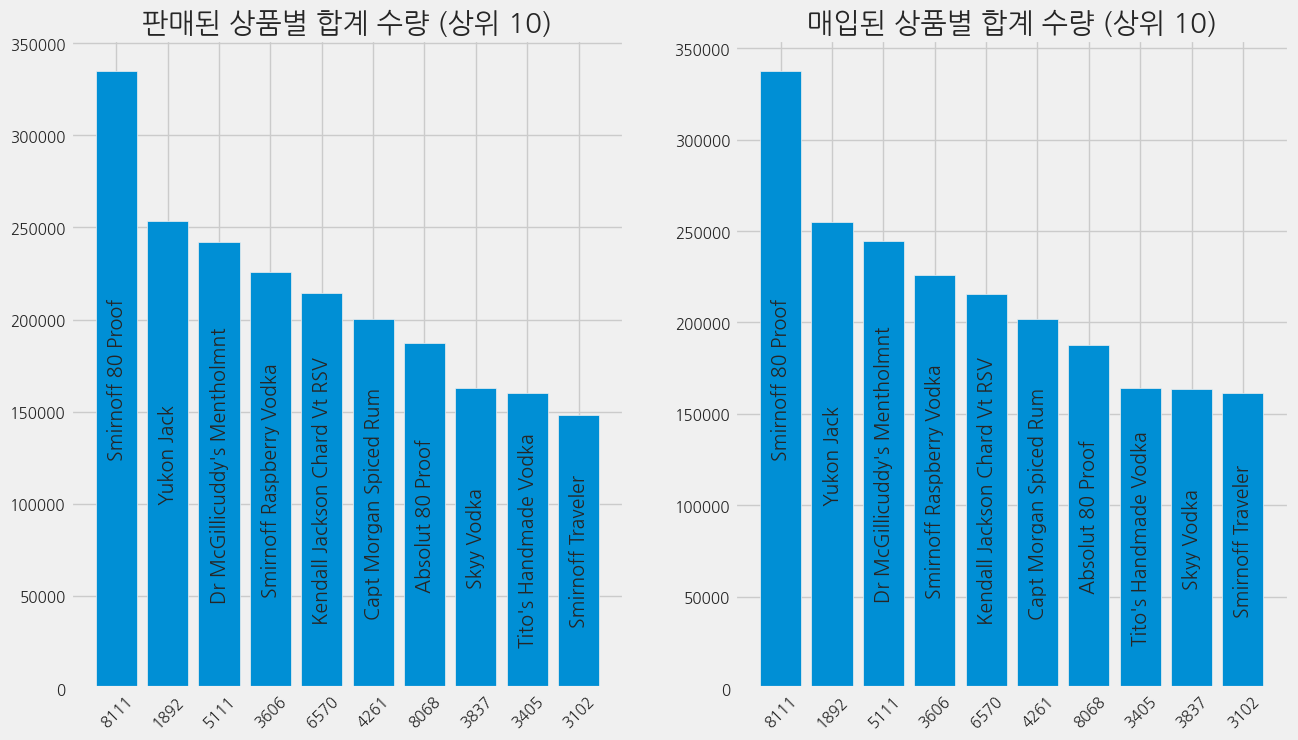

In [36]:
sales_brand_grouped = sales.groupby('Brand')\
                .agg({'SalesQuantity': 'sum',
                      'Description':'first'})\
    .reset_index().sort_values(by = 'SalesQuantity', ascending =False).head(10)

fig, ax = plt.subplots(1,2, figsize=(14,8))

bar_container = ax[0].bar(sales_brand_grouped.Brand, sales_brand_grouped.SalesQuantity)
ax[0].set(title = '판매된 상품별 합계 수량 (상위 10)')
ax[0].bar_label(bar_container, labels=sales_brand_grouped.Description,
             rotation=90,
             label_type='center')
ax[0].tick_params(axis='x', rotation=45)

bar_container_1 = ax[1].bar(purc_brand_grouped.Brand, purc_brand_grouped.Quantity)
ax[1].set(title = '매입된 상품별 합계 수량 (상위 10)')
ax[1].bar_label(bar_container_1, labels=purc_brand_grouped.Description,
             rotation=90,
             label_type='center')
ax[1].tick_params(axis='x', rotation=45)

Text(0.7, 5799.99, 'max: 5799.99')

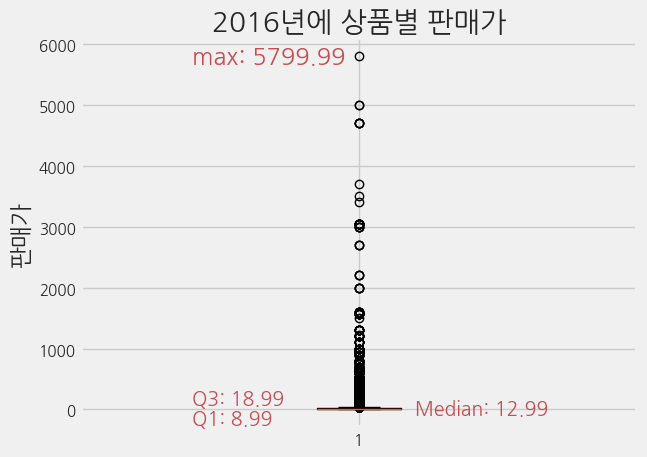

In [37]:
fig, axs = plt.subplots()

axs.boxplot(sales.SalesPrice)
axs.set_title("2016년에 상품별 판매가")
axs.set_ylabel('판매가')

q1_s = np.percentile(sales.SalesPrice, 25)
median_s = np.median(sales.SalesPrice)
q3_s = np.percentile(sales.SalesPrice, 75)
max_s = np.max(sales.SalesPrice)

axs.text(1.1, median_s, f'Median: {median_s:.2f}', va = 'center', color = 'r')
axs.text(0.7, q1_s, f'Q1: {q1_s:.2f}', va = 'top', color = 'r')
axs.text(0.7, q3_s, f'Q3: {q3_s:.2f}', va = 'bottom', color = 'r')
axs.text(0.7, max_s, f'max: {max_s:.2f}', va = 'center', color = 'r', fontsize = 17)

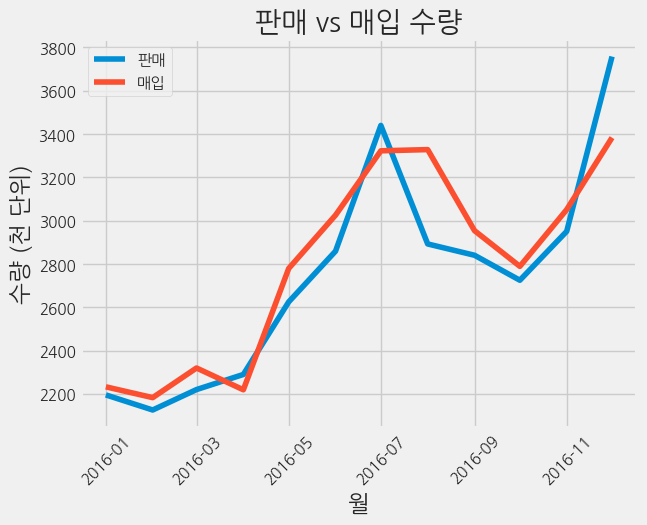

In [38]:
sales['SalesMonth'] = sales.SalesDate.dt.to_period('M')
sales_group_month = sales.groupby('SalesMonth')['SalesQuantity'].sum().div(1000).reset_index()
sales_group_month['SalesMonth'] = sales_group_month['SalesMonth'].dt.to_timestamp()
plt.plot(sales_group_month.SalesMonth, sales_group_month.SalesQuantity, label = '판매')
plt.plot(purc_group_month.PurchasesMonth, purc_group_month.Quantity, label = '매입')
plt.title('판매 vs 매입 수량' )
plt.xlabel('월')
plt.xticks(rotation=45)
plt.ylabel('수량 (천 단위)')
plt.legend()

In [39]:
sales.groupby('Brand')['SalesPrice'].nunique()

Brand
100      2
1000     4
10009    1
1001     1
10010    1
        ..
994      2
995      3
996      1
998      3
999      2
Name: SalesPrice, Length: 11237, dtype: int64

> 일년간 제품 매출 가격에 변동이 있었기 때문에, 매출 데이터 처리 시에는 각 제품의 평균 판매 가격을 적용하여 수익을 계산할 계획입니다.

In [40]:
sales[sales['SalesPrice']==0]

,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName,SalesMonth
1251465,38_GOULCREST_25340,38,25340,Dom La Soumade Rast Prestige,750mL,3,0.0,0.0,2016-02-13,750.0,2,0.34,4425,MARTIGNETTI COMPANIES,2016-02
1572292,66_EANVERNESS_25340,66,25340,Dom La Soumade Rast Prestige,750mL,3,0.0,0.0,2016-02-12,750.0,2,0.34,4425,MARTIGNETTI COMPANIES,2016-02
1572293,66_EANVERNESS_25340,66,25340,Dom La Soumade Rast Prestige,750mL,1,0.0,0.0,2016-02-16,750.0,2,0.11,4425,MARTIGNETTI COMPANIES,2016-02
1602468,67_EANVERNESS_25340,67,25340,Dom La Soumade Rast Prestige,750mL,12,0.0,0.0,2016-02-07,750.0,2,1.35,4425,MARTIGNETTI COMPANIES,2016-02
1713234,73_DONCASTER_25340,73,25340,Dom La Soumade Rast Prestige,750mL,1,0.0,0.0,2016-02-15,750.0,2,0.11,4425,MARTIGNETTI COMPANIES,2016-02
3781435,15_WANBORNE_19465,15,19465,Flagstone Longitude Red,750mL,13,0.0,0.0,2016-05-02,750.0,2,1.46,2000,SOUTHERN WINE & SPIRITS NE,2016-05
3876771,23_ARBINGTON_19465,23,19465,Flagstone Longitude Red,750mL,6,0.0,0.0,2016-05-04,750.0,2,0.68,2000,SOUTHERN WINE & SPIRITS NE,2016-05
3995644,34_PITMERDEN_19465,34,19465,Flagstone Longitude Red,750mL,1,0.0,0.0,2016-05-02,750.0,2,0.11,2000,SOUTHERN WINE & SPIRITS NE,2016-05
4251446,54_GUTHRAM_19465,54,19465,Flagstone Longitude Red,750mL,1,0.0,0.0,2016-05-02,750.0,2,0.11,2000,SOUTHERN WINE & SPIRITS NE,2016-05
4251447,54_GUTHRAM_19465,54,19465,Flagstone Longitude Red,750mL,2,0.0,0.0,2016-05-04,750.0,2,0.22,2000,SOUTHERN WINE & SPIRITS NE,2016-05


In [41]:
sales[sales['Brand']== '3046']['SalesPrice'].unique()

array([56.99, 47.99, 48.99,  0.  ])

> 일부 제품은 프로모션으로 무료 증정된 내역이 있어 `SalesDollars`가 0인 행 제거  
> 분석에 필요한 열(`Brand`, `SalesQuantity`, `SalesDollars`, `ExciseTax`)만 추출  
> 세금을 제외한 순매출(`NetSales`) 계산: SalesDollars - ExciseTax  
> 원본 금액 열(`SalesDollars`, `ExciseTax`) 삭제

In [42]:
sold_products = sales[sales['SalesDollars']!=0][['Brand', 'SalesQuantity', 'SalesDollars', 'ExciseTax']]
sold_products['NetSales'] = sold_products['SalesDollars'] - sold_products['ExciseTax']
sold_products = sold_products.drop(columns =['ExciseTax', 'SalesDollars'])

array([[<Axes: title={'center': 'SalesQuantity'}>,
        <Axes: title={'center': 'NetSales'}>]], dtype=object)

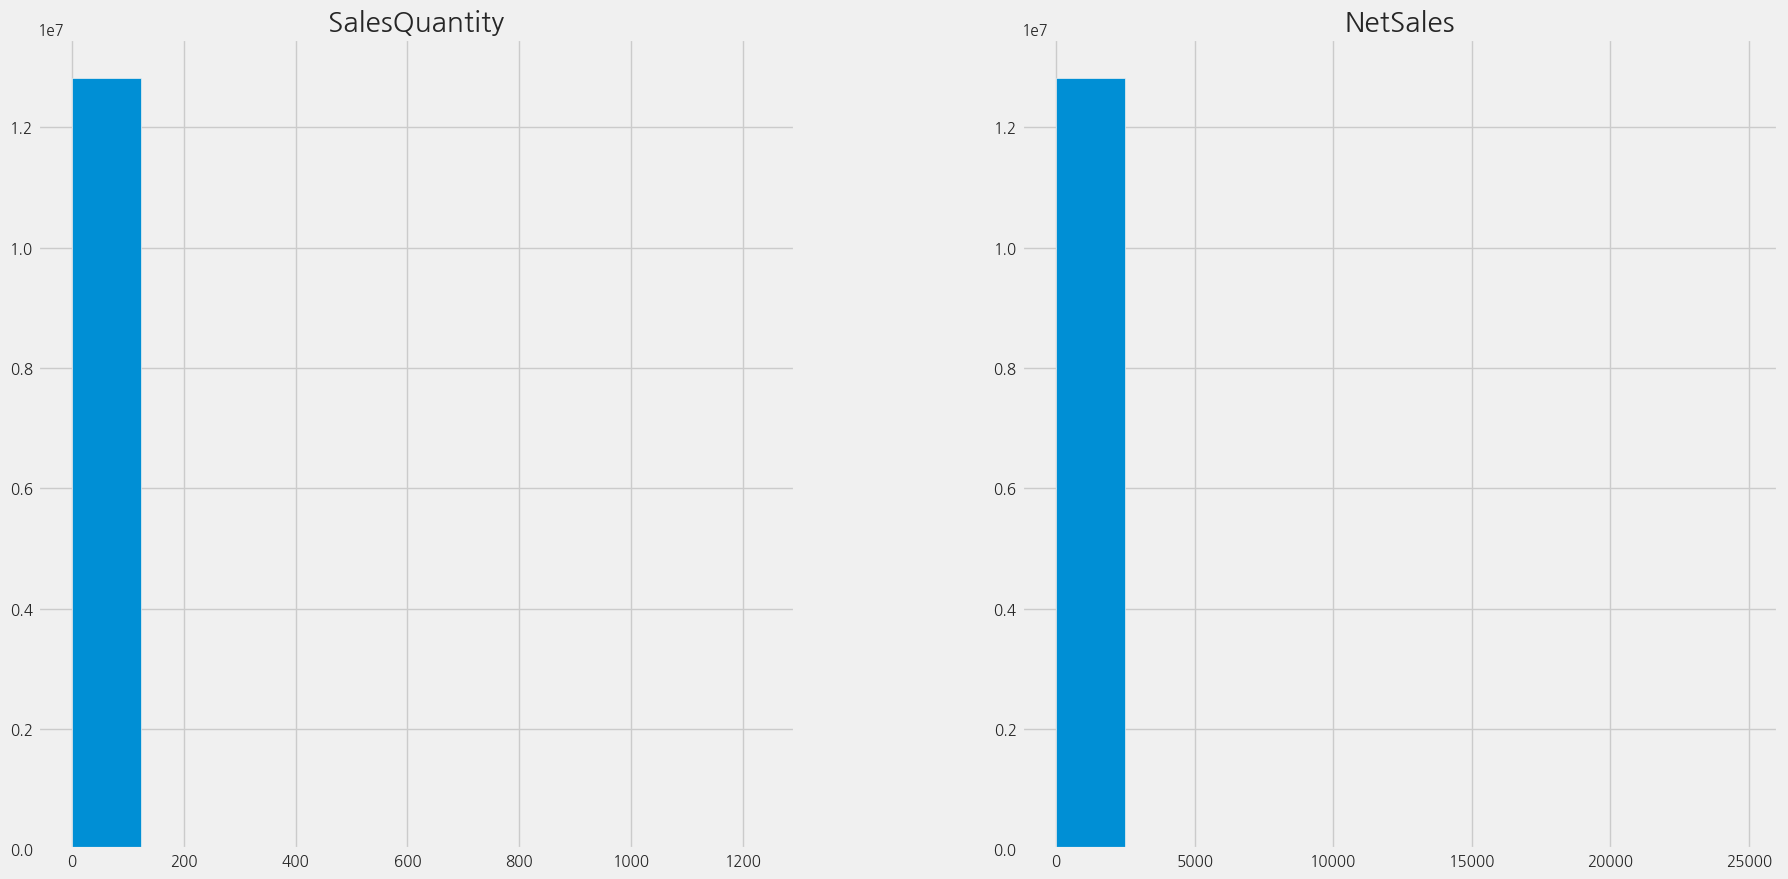

In [43]:
sold_products.hist(figsize = (20,10))

In [44]:
pd.set_option('display.float_format', '{:,.2f}'.format)
sold_products.describe()

,SalesQuantity,NetSales
count,"12,825,308.00","12,825,308.00"
mean,2.57,33.77
std,4.55,84.79
min,1.00,0.44
25%,1.00,10.47
50%,1.00,18.15
75%,2.00,33.76
max,"1,231.00","24,818.40"


> 브랜드별로 그룹화하여   
> 총 판매 수량(`SalesQuantity`) 합계 계산  
> 순매출(`NetSales`) 합계 계산   
> 브랜드별 평균 판매가(`AvgPrice`) 계산: `NetSales` ÷ `SalesQuantity`

In [45]:
sold_product_grouped = sold_products.groupby('Brand')\
    .agg({'SalesQuantity': 'sum',
          'NetSales' :'sum'})
sold_product_grouped['AvgPrice'] = sold_product_grouped['NetSales']/sold_product_grouped['SalesQuantity']

In [46]:
sold_product_grouped

,SalesQuantity,NetSales,AvgPrice
Brand,,,
100,124,"20,170.98",162.67
1000,62,988.50,15.94
10009,35,205.74,5.88
1001,7927,"47,073.23",5.94
10010,6,35.28,5.88
...,...,...,...
994,132,"2,658.08",20.14
995,188,"3,682.72",19.59
996,15,"4,488.00",299.20


### 제품별 수익 데이플 생성

In [47]:
profit_table  = sold_product_grouped.merge(total_stock[['Brand','PurchasePrice']], on = 'Brand', how = 'left')

In [48]:
profit_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11237 entries, 0 to 11236
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Brand          11237 non-null  object 
 1   SalesQuantity  11237 non-null  int64  
 2   NetSales       11237 non-null  float64
 3   AvgPrice       11237 non-null  float64
 4   PurchasePrice  10485 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 439.1+ KB


In [49]:
profit_table

,Brand,SalesQuantity,NetSales,AvgPrice,PurchasePrice
0,100,124,"20,170.98",162.67,120.29
1,1000,62,988.50,15.94,11.62
2,10009,35,205.74,5.88,4.13
3,1001,7927,"47,073.23",5.94,4.28
4,10010,6,35.28,5.88,3.86
...,...,...,...,...,...
11232,994,132,"2,658.08",20.14,14.81
11233,995,188,"3,682.72",19.59,15.99
11234,996,15,"4,488.00",299.20,222.21
11235,998,676,"16,974.11",25.11,18.51


> 제품 구매 가격 값 중에 결측치 있습니다.
> 결측치를 채우기 위한 제품 판매가격을 정할 때 적용하는 마크업을 계산하려고 합니다

In [50]:
profit_table_markup = profit_table[profit_table['PurchasePrice'].notna()].copy()

In [51]:
profit_table_markup.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10485 entries, 0 to 11236
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Brand          10485 non-null  object 
 1   SalesQuantity  10485 non-null  int64  
 2   NetSales       10485 non-null  float64
 3   AvgPrice       10485 non-null  float64
 4   PurchasePrice  10485 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 491.5+ KB


In [52]:
profit_table_markup['Markup'] = profit_table_markup['AvgPrice'].div(profit_table_markup['PurchasePrice']).sub(1)
avg_markup = profit_table_markup['Markup'].mean()
avg_markup

np.float64(0.4572397549968067)

In [53]:
profit_table['PurchasePrice'] = profit_table['PurchasePrice'].fillna(profit_table['AvgPrice']/(1+avg_markup))
profit_table['TTLPurchase'] = profit_table['PurchasePrice'] *profit_table['SalesQuantity'] 
profit_table['Profit'] = profit_table['NetSales'] - profit_table['TTLPurchase']
profit_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11237 entries, 0 to 11236
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Brand          11237 non-null  object 
 1   SalesQuantity  11237 non-null  int64  
 2   NetSales       11237 non-null  float64
 3   AvgPrice       11237 non-null  float64
 4   PurchasePrice  11237 non-null  float64
 5   TTLPurchase    11237 non-null  float64
 6   Profit         11237 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 614.7+ KB


## 4. ABC 분석

> `Profit` 기준 내림차순으로 정렬  
> 누적 이익(`Run_Profit`) 계산  
> 전체 이익 합계(`total_profit_value`) 계산  
> 누적 이익 비율(`run_perc`) 계산: `Run_Profit` ÷ `total_profit_value`

In [54]:
profit_table = profit_table.sort_values(by='Profit', ascending = False)
profit_table

,Brand,SalesQuantity,NetSales,AvgPrice,PurchasePrice,TTLPurchase,Profit
476,1233,142049,"4,840,920.31",34.08,26.27,"3,731,627.23","1,109,293.08"
7740,3545,135838,"3,973,519.79",29.25,21.89,"2,973,493.82","1,000,025.97"
8910,4261,200412,"4,107,730.08",20.50,16.17,"3,240,662.04","867,068.04"
10319,6570,214238,"2,301,924.01",10.74,6.77,"1,450,391.26","851,532.75"
7543,3405,160247,"4,524,634.83",28.24,23.19,"3,716,127.93","808,506.90"
...,...,...,...,...,...,...,...
149,10666,5636,"30,556.40",5.42,7.74,"43,622.64","-13,066.24"
7440,33331,7236,"64,254.63",8.88,10.73,"77,642.28","-13,387.65"
9273,44714,9925,"118,508.31",11.94,13.51,"134,086.75","-15,578.44"
6282,26710,4995,"25,471.13",5.10,9.26,"46,253.70","-20,782.57"


마이너스 수익인 상품이 있으며 추가 확인 진행합니다.   
해당 상품들은 주로 프로모션 또는 할인 판매로 인해 일시적으로 마이너스 수익이 발생한 것으로 판단됩니다.

In [55]:
profit_table['profit_flag'] = profit_table['Profit']\
    .apply(lambda x: "Loss" if x<0 else "Profit")

In [56]:
negative_profit = profit_table[profit_table['Profit'] <0].copy()
negative_profit['ABC_category'] = 'C'
negative_profit.head()

,Brand,SalesQuantity,NetSales,AvgPrice,PurchasePrice,TTLPurchase,Profit,profit_flag,ABC_category
8984,430,28,48.72,1.74,1.99,55.72,-7.00,Loss,C
8817,4207,29,50.46,1.74,2.05,59.45,-8.99,Loss,C
5101,24591,219,"2,108.44",9.63,9.67,"2,117.73",-9.29,Loss,C
9601,46929,18,112.81,6.27,6.80,122.40,-9.59,Loss,C
9685,4904,458,"7,030.29",15.35,15.38,"7,044.04",-13.75,Loss,C


In [57]:
purchases[purchases['Brand'] == '4904'].groupby('PurchasePrice').agg({'Quantity':'sum'})

,Quantity
PurchasePrice,
15.38,1060


In [58]:
sales[sales['Brand'] == '4904'].groupby('SalesPrice').agg({'SalesQuantity': 'sum'})

,SalesQuantity
SalesPrice,
15.99,441
19.99,17


In [59]:
profit_table = profit_table[profit_table['Profit']>0]
profit_table

,Brand,SalesQuantity,NetSales,AvgPrice,PurchasePrice,TTLPurchase,Profit,profit_flag
476,1233,142049,"4,840,920.31",34.08,26.27,"3,731,627.23","1,109,293.08",Profit
7740,3545,135838,"3,973,519.79",29.25,21.89,"2,973,493.82","1,000,025.97",Profit
8910,4261,200412,"4,107,730.08",20.50,16.17,"3,240,662.04","867,068.04",Profit
10319,6570,214238,"2,301,924.01",10.74,6.77,"1,450,391.26","851,532.75",Profit
7543,3405,160247,"4,524,634.83",28.24,23.19,"3,716,127.93","808,506.90",Profit
...,...,...,...,...,...,...,...,...
10553,746,1,4.94,4.94,4.61,4.61,0.33,Profit
6693,2773,1,0.94,0.94,0.65,0.65,0.29,Profit
9831,5287,2,0.88,0.44,0.30,0.60,0.28,Profit
10497,726,1,4.94,4.94,4.79,4.79,0.15,Profit


>구매가가 판매가보다 높아 일부 상품에서 마이너스 수익이 발생하였습니다.       
>본 분석은 수익 기준으로 ABC 분석을 수행하므로, 파레토 분포의 왜곡을 방지하기 위해     
>마이너스 수익 상품은 ABC 분석 대상에서 분리하고 C 카테고리로 별도 분류하였습니다.     
>또한 모든 상품에 대해 수익 여부를 명확히 구분하기 위해 profit flag 컬럼을 추가하였습니다.    

In [60]:
profit_table['Run_Profit'] = profit_table['Profit'].cumsum()

C:\Users\annaz\AppData\Local\Temp\ipykernel_11156\408756306.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profit_table['Run_Profit'] = profit_table['Profit'].cumsum()


In [61]:
total_profit_value = profit_table['Profit'].sum()
total_profit_value

np.float64(119974910.16853859)

In [62]:
profit_table['run_perc'] = profit_table['Run_Profit']/total_profit_value

C:\Users\annaz\AppData\Local\Temp\ipykernel_11156\3849389951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profit_table['run_perc'] = profit_table['Run_Profit']/total_profit_value


In [63]:
profit_table

,Brand,SalesQuantity,NetSales,AvgPrice,PurchasePrice,TTLPurchase,Profit,profit_flag,Run_Profit,run_perc
476,1233,142049,"4,840,920.31",34.08,26.27,"3,731,627.23","1,109,293.08",Profit,"1,109,293.08",0.01
7740,3545,135838,"3,973,519.79",29.25,21.89,"2,973,493.82","1,000,025.97",Profit,"2,109,319.05",0.02
8910,4261,200412,"4,107,730.08",20.50,16.17,"3,240,662.04","867,068.04",Profit,"2,976,387.09",0.02
10319,6570,214238,"2,301,924.01",10.74,6.77,"1,450,391.26","851,532.75",Profit,"3,827,919.84",0.03
7543,3405,160247,"4,524,634.83",28.24,23.19,"3,716,127.93","808,506.90",Profit,"4,636,426.74",0.04
...,...,...,...,...,...,...,...,...,...,...
10553,746,1,4.94,4.94,4.61,4.61,0.33,Profit,"119,974,909.35",1.00
6693,2773,1,0.94,0.94,0.65,0.65,0.29,Profit,"119,974,909.64",1.00
9831,5287,2,0.88,0.44,0.30,0.60,0.28,Profit,"119,974,909.92",1.00
10497,726,1,4.94,4.94,4.79,4.79,0.15,Profit,"119,974,910.07",1.00


> 누적 이익 비율(`run_perc`)을 기준으로 ABC 분석 카테고리 지정

In [64]:
def ABC(run_perc):
    if run_perc < 0.8:
        return 'A'
    elif run_perc >= 0.8 and run_perc < 0.95:
        return 'B'
    elif run_perc >= 0.95:
        return 'C'

profit_table['ABC_category'] = profit_table['run_perc'].apply(ABC)

C:\Users\annaz\AppData\Local\Temp\ipykernel_11156\243370310.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profit_table['ABC_category'] = profit_table['run_perc'].apply(ABC)


In [65]:
profit_table

,Brand,SalesQuantity,NetSales,AvgPrice,PurchasePrice,TTLPurchase,Profit,profit_flag,Run_Profit,run_perc,ABC_category
476,1233,142049,"4,840,920.31",34.08,26.27,"3,731,627.23","1,109,293.08",Profit,"1,109,293.08",0.01,A
7740,3545,135838,"3,973,519.79",29.25,21.89,"2,973,493.82","1,000,025.97",Profit,"2,109,319.05",0.02,A
8910,4261,200412,"4,107,730.08",20.50,16.17,"3,240,662.04","867,068.04",Profit,"2,976,387.09",0.02,A
10319,6570,214238,"2,301,924.01",10.74,6.77,"1,450,391.26","851,532.75",Profit,"3,827,919.84",0.03,A
7543,3405,160247,"4,524,634.83",28.24,23.19,"3,716,127.93","808,506.90",Profit,"4,636,426.74",0.04,A
...,...,...,...,...,...,...,...,...,...,...,...
10553,746,1,4.94,4.94,4.61,4.61,0.33,Profit,"119,974,909.35",1.00,C
6693,2773,1,0.94,0.94,0.65,0.65,0.29,Profit,"119,974,909.64",1.00,C
9831,5287,2,0.88,0.44,0.30,0.60,0.28,Profit,"119,974,909.92",1.00,C
10497,726,1,4.94,4.94,4.79,4.79,0.15,Profit,"119,974,910.07",1.00,C


In [66]:
profit_table= pd.concat(
    [profit_table, negative_profit],
    axis=0,
    ignore_index=True)

profit_table["abc_scope"] = np.where(
    profit_table["profit_flag"] == "Profit",
    "Pareto_scope",
    "Excluded_from_Pareto"
)

profit_table["margin_pct"] = profit_table["Profit"] / profit_table["NetSales"]
profit_table

,Brand,SalesQuantity,NetSales,AvgPrice,PurchasePrice,TTLPurchase,Profit,profit_flag,Run_Profit,run_perc,ABC_category,abc_scope,margin_pct
0,1233,142049,"4,840,920.31",34.08,26.27,"3,731,627.23","1,109,293.08",Profit,"1,109,293.08",0.01,A,Pareto_scope,0.23
1,3545,135838,"3,973,519.79",29.25,21.89,"2,973,493.82","1,000,025.97",Profit,"2,109,319.05",0.02,A,Pareto_scope,0.25
2,4261,200412,"4,107,730.08",20.50,16.17,"3,240,662.04","867,068.04",Profit,"2,976,387.09",0.02,A,Pareto_scope,0.21
3,6570,214238,"2,301,924.01",10.74,6.77,"1,450,391.26","851,532.75",Profit,"3,827,919.84",0.03,A,Pareto_scope,0.37
4,3405,160247,"4,524,634.83",28.24,23.19,"3,716,127.93","808,506.90",Profit,"4,636,426.74",0.04,A,Pareto_scope,0.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11232,10666,5636,"30,556.40",5.42,7.74,"43,622.64","-13,066.24",Loss,NaN,NaN,C,Excluded_from_Pareto,-0.43
11233,33331,7236,"64,254.63",8.88,10.73,"77,642.28","-13,387.65",Loss,NaN,NaN,C,Excluded_from_Pareto,-0.21
11234,44714,9925,"118,508.31",11.94,13.51,"134,086.75","-15,578.44",Loss,NaN,NaN,C,Excluded_from_Pareto,-0.13
11235,26710,4995,"25,471.13",5.10,9.26,"46,253.70","-20,782.57",Loss,NaN,NaN,C,Excluded_from_Pareto,-0.82


In [67]:
#ABC 카테고리별 상품 수량/비율 
category_share = profit_table['ABC_category'].value_counts()
category_share = category_share.reset_index()
category_share.columns = ['Category', 'Count']
category_share.Count.sum()
ttl = profit_table['ABC_category'].value_counts().sum()
category_share['Perc'] = (category_share.Count/ttl)*100
category_share

,Category,Count,Perc
0,C,7558,67.26
1,B,2034,18.10
2,A,1645,14.64


In [68]:
#ABC 카테고리별 수익/비율
profit_share = profit_table.groupby('ABC_category').agg({'Profit': 'sum'})
profit_share = profit_share.reset_index()
profit_share.columns = ['Category', 'Profit']
ttl = profit_share['Profit'].sum()
profit_share ['Perc'] = (profit_share.Profit/ttl)*100
profit_share

,Category,Profit,Perc
0,A,"95,968,543.99",80.22
1,B,"18,006,377.04",15.05
2,C,"5,663,109.49",4.73


Text(0.5, 1.0, 'ABC 카테고리별 수익 기여도')

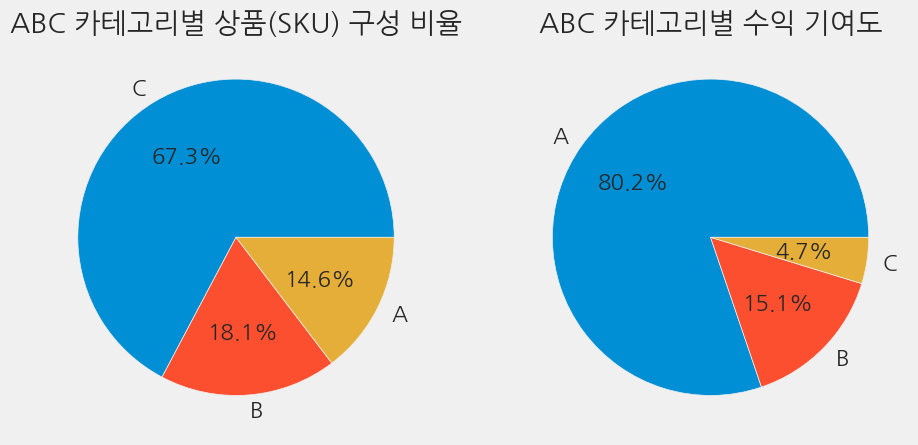

In [69]:
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.pie(category_share.Perc, labels = ['C', 'B', 'A'], autopct='%1.1f%%', textprops={'fontsize': 16})
plt.title('ABC 카테고리별 상품(SKU) 구성 비율')
plt.subplot(1,2,2)
plt.pie(profit_share.Perc, labels = ['A', 'B', 'C'], autopct = '%1.1f%%', textprops={'fontsize': 16})
plt.title('ABC 카테고리별 수익 기여도')

> 전체 상품의 약 14.5%에 해당하는 A 카테고리 상품이 전체 수익의 약 80.4%를 차지하는 것으로 나타났습니다.     
> 반면 C 카테고리 상품은 전체 상품의 약 67.7%를 차지하지만 수익 기여도는 4.5% 수준에 그쳤습니다.     
> 이를 통해 소수의 핵심 상품이 전체 수익을 주도하는 파레토 구조가 명확히 확인되었습니다.    

## 5. XYZ 분석

>XYZ 분석은 수요 변동성을 기준으로 수행되므로, 수익 여부와 관계없이 모든 상품을 분석 대상에 포함하였습니다.    
>이를 통해 마이너스 수익 상품의 수요 안정성까지 함께 평가할 수 있습니다. 

In [70]:
sales.head()

,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName,SalesMonth
0,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2016-01-01,750.00,1,0.79,12546,JIM BEAM BRANDS COMPANY,2016-01
1,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,2,32.98,16.49,2016-01-02,750.00,1,1.57,12546,JIM BEAM BRANDS COMPANY,2016-01
2,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,2016-01-03,750.00,1,0.79,12546,JIM BEAM BRANDS COMPANY,2016-01
3,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,14.49,14.49,2016-01-08,750.00,1,0.79,12546,JIM BEAM BRANDS COMPANY,2016-01
4,1_HARDERSFIELD_1005,1,1005,Maker's Mark Combo Pack,375mL 2 Pk,2,69.98,34.99,2016-01-09,375.00,1,0.79,12546,JIM BEAM BRANDS COMPANY,2016-01


> 판매 데이터에서 `Brand`, `SalesQuantity`, `SalesDate` 열만 추출  
> 판매일자를 월 단위로 변환(`SaleMonth`)  
> 브랜드와 월별로 그룹화하여 해당 월의 총 판매 수량 합계 계산

In [71]:
sales_frequency = sales[['Brand', 'SalesQuantity', 'SalesDate']].copy()
sales_frequency['SaleMonth'] = sales_frequency['SalesDate'].dt.to_period('M')
sales_frequency = sales_frequency.drop(columns = ['SalesDate'])
sales_frequency_grouped = sales_frequency.groupby(['Brand', 'SaleMonth'])['SalesQuantity'].sum()
sales_frequency_grouped

Brand  SaleMonth
100    2016-01        7
       2016-02       11
       2016-03        5
       2016-04       15
       2016-05        7
                   ... 
999    2016-08       44
       2016-09       45
       2016-10       40
       2016-11       40
       2016-12      155
Name: SalesQuantity, Length: 94088, dtype: int64

> 월별 판매 빈도를 계산하기 위해 월별 판매 수량을 제품별로 피벗 테이블 형태로 변환  
> 결측값은 0으로 채움

In [72]:
sales_by_month = sales_frequency_grouped.reset_index()\
    .pivot(index ='Brand',
           columns ='SaleMonth',
           values = 'SalesQuantity').fillna(0)

> 제품별 월별 평균 판매량과 표준편차를 계산  
> 변동계수(CV) 계산: StdSales ÷ AvgSalesQ-ty

In [73]:
sales_by_month['AvgSalesQ-ty'] = sales_by_month.mean(axis = 1)
sales_by_month['StdSales'] = sales_by_month.std(axis = 1)
sales_by_month['CV'] = sales_by_month['StdSales']/sales_by_month['AvgSalesQ-ty']

In [74]:
sales_by_month

SaleMonth,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,AvgSalesQ-ty,StdSales,CV
Brand,,,,,,,,,,,,,,,
100,7.00,11.00,5.00,15.00,7.00,19.00,17.00,4.00,7.00,7.00,12.00,13.00,10.33,4.70,0.45
1000,28.00,21.00,6.00,6.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.17,9.03,1.75
10009,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,32.00,2.92,8.79,3.01
1001,833.00,357.00,204.00,66.00,76.00,25.00,421.00,"1,184.00","1,458.00","1,329.00","1,331.00",643.00,660.58,523.88,0.79
10010,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,1.00,0.50,1.38,2.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,13.00,15.00,10.00,15.00,13.00,14.00,13.00,3.00,4.00,10.00,12.00,10.00,11.00,3.76,0.34
995,12.00,19.00,16.00,25.00,21.00,19.00,15.00,19.00,6.00,12.00,11.00,13.00,15.67,4.99,0.32
996,0.00,1.00,1.00,0.00,0.00,2.00,3.00,2.00,4.00,1.00,1.00,0.00,1.25,1.23,0.99


In [75]:
sales_by_month['CV'].describe()

count   11,237.00
mean         1.21
std          0.93
min          0.04
25%          0.43
50%          0.92
75%          1.73
max          3.32
Name: CV, dtype: float64

> 제품 수요 변동 계수(CV)의 중앙값이 0.92이므로,  
> 제품 수요 분포를 반영하여 카테고리를 합리적으로 구분하기 위해  
> 기준점을 0.5와 1로 지정

In [76]:
def xyz(cv):
    if cv <= 0.5:
        return 'X'
    elif cv <= 1:
        return 'Y'
    else:
        return 'Z'

> CV 분포 분석 결과를 바탕으로 XYZ 분류 기준을 설정하였습니다.    
> CV ≤ 0.5는 수요가 안정적인 상품(X),    
> 0.5 < CV ≤ 1.0은 중간 수준의 변동성을 가진 상품(Y),   
> CV > 1.0은 수요 변동성이 높은 상품(Z)으로 분류하였습니다.   

In [77]:
sales_by_month['XYZ_Category'] = sales_by_month['CV'].apply(xyz)

In [78]:
sales_by_month

SaleMonth,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,AvgSalesQ-ty,StdSales,CV,XYZ_Category
Brand,,,,,,,,,,,,,,,,
100,7.00,11.00,5.00,15.00,7.00,19.00,17.00,4.00,7.00,7.00,12.00,13.00,10.33,4.70,0.45,X
1000,28.00,21.00,6.00,6.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.17,9.03,1.75,Z
10009,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00,32.00,2.92,8.79,3.01,Z
1001,833.00,357.00,204.00,66.00,76.00,25.00,421.00,"1,184.00","1,458.00","1,329.00","1,331.00",643.00,660.58,523.88,0.79,Y
10010,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,0.00,0.00,1.00,0.50,1.38,2.77,Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,13.00,15.00,10.00,15.00,13.00,14.00,13.00,3.00,4.00,10.00,12.00,10.00,11.00,3.76,0.34,X
995,12.00,19.00,16.00,25.00,21.00,19.00,15.00,19.00,6.00,12.00,11.00,13.00,15.67,4.99,0.32,X
996,0.00,1.00,1.00,0.00,0.00,2.00,3.00,2.00,4.00,1.00,1.00,0.00,1.25,1.23,0.99,Y


In [79]:
XYZ_category_share = sales_by_month['XYZ_Category'].value_counts()
XYZ_category_share = XYZ_category_share.reset_index()
XYZ_category_share.columns = ['Category', 'Count']

Text(0.5, 1.0, 'XYZ 카테고리별 상품(SKU) 구성 비율')

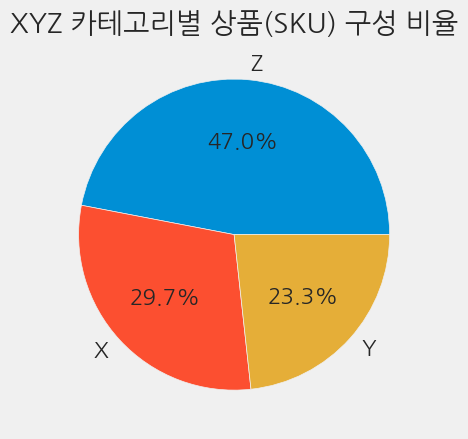

In [80]:
XYZ_category_share['Perc'] = (XYZ_category_share.Count/ttl) * 100 
plt.pie(XYZ_category_share.Count, labels = XYZ_category_share.Category, autopct = '%1.1f%%', textprops = {'fontsize': 16})
plt.title('XYZ 카테고리별 상품(SKU) 구성 비율')

## 6. Dead Stock

> 매출 기록이 있는 InventoryId 리스트 생성 후  
> 기초 재고 데이터에서 해당 InventoryId가 없는 건 추출

In [81]:
sales_id_series = pd.Series(sales['InventoryId'].unique(), name = 'InventoryId')

In [82]:
dead_stock  = srtinv[~srtinv['InventoryId'].isin(sales_id_series)]

In [83]:
dead_stock = dead_stock[['InventoryId','Brand', 'Store', 'Description', 'onHand', 'Price']]

In [84]:
dead_stock

,InventoryId,Brand,Store,Description,onHand,Price
30,1_HARDERSFIELD_356,356,1,Carolans Irish Cr Gift Set,0,11.49
41,1_HARDERSFIELD_425,425,1,Hennessy Paradis,1,799.99
101,1_HARDERSFIELD_883,883,1,Patron Burdeos Anejo Tequila,2,499.99
114,1_HARDERSFIELD_999,999,1,Jameson 18 Year Old,0,119.99
115,1_HARDERSFIELD_1000,1000,1,Goslings Dark'n Stormy VAP,0,14.99
...,...,...,...,...,...,...
205685,79_BALLYMENA_22759,22759,79,Meiomi Pnt Nr,0,12.99
205746,79_BALLYMENA_23848,23848,79,Dom Cherrier Sancerre,0,17.99
205765,79_BALLYMENA_24328,24328,79,Ch Ducru Beaucaillou 12 St J,5,154.99
206171,79_BALLYMENA_36766,36766,79,Ravenswood Znfdl Lodi,0,16.99


In [85]:
dead_stock = dead_stock[dead_stock['onHand'] !=0]

> 제품별 구매가 불러오기

In [86]:
dead_stock = dead_stock.merge(year_stock_grouped[['Brand', 'PurchasePrice']], on = 'Brand', how = 'left')

In [87]:
dead_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938 entries, 0 to 937
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   InventoryId    938 non-null    object 
 1   Brand          938 non-null    object 
 2   Store          938 non-null    object 
 3   Description    938 non-null    object 
 4   onHand         938 non-null    int64  
 5   Price          938 non-null    float64
 6   PurchasePrice  842 non-null    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 51.4+ KB


In [88]:
dead_stock['PurchasePrice'] = dead_stock['PurchasePrice']\
    .fillna(dead_stock['Price']/(1+avg_markup))

In [89]:
dead_stock.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938 entries, 0 to 937
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   InventoryId    938 non-null    object 
 1   Brand          938 non-null    object 
 2   Store          938 non-null    object 
 3   Description    938 non-null    object 
 4   onHand         938 non-null    int64  
 5   Price          938 non-null    float64
 6   PurchasePrice  938 non-null    float64
dtypes: float64(2), int64(1), object(4)
memory usage: 51.4+ KB


In [90]:
# Tableau 대시보드용 데이터파일 
#dead_stock.to_csv('dead_stock.csv', index = False)

In [91]:
dead_stock_grouped = dead_stock.groupby(['Brand', 'Description'])\
    .agg({'onHand' : 'sum',
          'Price' : 'first',
          'PurchasePrice': 'first',
          'Store' : lambda x : len(set(x))})

In [92]:
dead_stock_grouped = dead_stock_grouped.reset_index()
dead_stock_grouped = dead_stock_grouped.rename(columns = {'Store' : 'NumberOfStores'})

In [93]:
dead_stock_grouped.sort_values(by = 'NumberOfStores', ascending = False)

,Brand,Description,onHand,Price,PurchasePrice,NumberOfStores
514,5370,DiSaronno Rsva Ltd Edition,18,349.99,255.47,11
9,1106,Aberfeldy Single Cask,120,229.99,155.55,11
517,5430,Grand Marnier Cuvee 1880,39,349.99,275.58,10
347,2532,The Macallan 12 Yr Old,39,134.99,96.89,8
470,425,Hennessy Paradis,10,799.99,620.15,8
...,...,...,...,...,...,...
625,976,McCormick Gold Label Bourbon,2,9.49,7.47,1
626,977,McCormick Scotch,3,11.49,8.98,1
627,979,Pancho Villa Rojo,3,7.79,5.90,1
628,981,McCormick Triple Sec,12,3.99,2.89,1


## 7. Summary

In [94]:
profit_table.head()

,Brand,SalesQuantity,NetSales,AvgPrice,PurchasePrice,TTLPurchase,Profit,profit_flag,Run_Profit,run_perc,ABC_category,abc_scope,margin_pct
0,1233,142049,"4,840,920.31",34.08,26.27,"3,731,627.23","1,109,293.08",Profit,"1,109,293.08",0.01,A,Pareto_scope,0.23
1,3545,135838,"3,973,519.79",29.25,21.89,"2,973,493.82","1,000,025.97",Profit,"2,109,319.05",0.02,A,Pareto_scope,0.25
2,4261,200412,"4,107,730.08",20.50,16.17,"3,240,662.04","867,068.04",Profit,"2,976,387.09",0.02,A,Pareto_scope,0.21
3,6570,214238,"2,301,924.01",10.74,6.77,"1,450,391.26","851,532.75",Profit,"3,827,919.84",0.03,A,Pareto_scope,0.37
4,3405,160247,"4,524,634.83",28.24,23.19,"3,716,127.93","808,506.90",Profit,"4,636,426.74",0.04,A,Pareto_scope,0.18


In [95]:
summary_table = pd.merge(profit_table[['Brand', 'SalesQuantity','NetSales', 'Profit', 'margin_pct', 'profit_flag', 'abc_scope', 'ABC_category',  ]],
                         sales_by_month[['XYZ_Category']],
                         on = 'Brand', how = 'left')

In [96]:
brand_descriptions = sales[['Brand', 'Description']].drop_duplicates(subset='Brand')
summary_table = pd.merge(summary_table, brand_descriptions, on = 'Brand', how = 'left')

In [97]:
summary_table = summary_table[['Brand', 'Description', 'SalesQuantity', 'NetSales', 'Profit' , 'margin_pct', 'profit_flag', 'abc_scope', 'ABC_category', 'XYZ_Category']]

In [98]:
present_stock = endinv.groupby('Brand')['onHand'].sum()
summary_table = pd.merge(summary_table, present_stock, on='Brand', how = 'left').fillna(0)

In [99]:
summary_table.head()

,Brand,Description,SalesQuantity,NetSales,Profit,margin_pct,profit_flag,abc_scope,ABC_category,XYZ_Category,onHand
0,1233,Jack Daniels No 7 Black,142049,"4,840,920.31","1,109,293.08",0.23,Profit,Pareto_scope,A,X,"15,047.00"
1,3545,Ketel One Vodka,135838,"3,973,519.79","1,000,025.97",0.25,Profit,Pareto_scope,A,X,"16,770.00"
2,4261,Capt Morgan Spiced Rum,200412,"4,107,730.08","867,068.04",0.21,Profit,Pareto_scope,A,X,"16,769.00"
3,6570,Kendall Jackson Chard Vt RSV,214238,"2,301,924.01","851,532.75",0.37,Profit,Pareto_scope,A,X,"13,016.00"
4,3405,Tito's Handmade Vodka,160247,"4,524,634.83","808,506.90",0.18,Profit,Pareto_scope,A,X,"12,268.00"


In [100]:
profit_share = summary_table.groupby('XYZ_Category').agg({'Profit': 'sum'})
profit_share = profit_share.reset_index()
profit_share.columns = ['Category', 'Profit']
ttl = profit_share['Profit'].sum()
profit_share ['Perc'] = (profit_share.Profit/ttl)*100
profit_share

,Category,Profit,Perc
0,X,"78,001,655.54",65.20
1,Y,"35,006,105.64",29.26
2,Z,"6,630,269.34",5.54


In [101]:
xyz_share = summary_table.groupby('XYZ_Category').agg({'Description': 'count'})
xyz_share = xyz_share.reset_index()
xyz_share.columns = ['Category', 'Quantity']
ttl = xyz_share['Quantity'].sum()
xyz_share['Perc'] = (xyz_share.Quantity/ttl)*100
xyz_share

,Category,Quantity,Perc
0,X,3343,29.75
1,Y,2615,23.27
2,Z,5279,46.98


Text(0.5, 1.0, 'XYZ 카테고리별 수익 기여도')

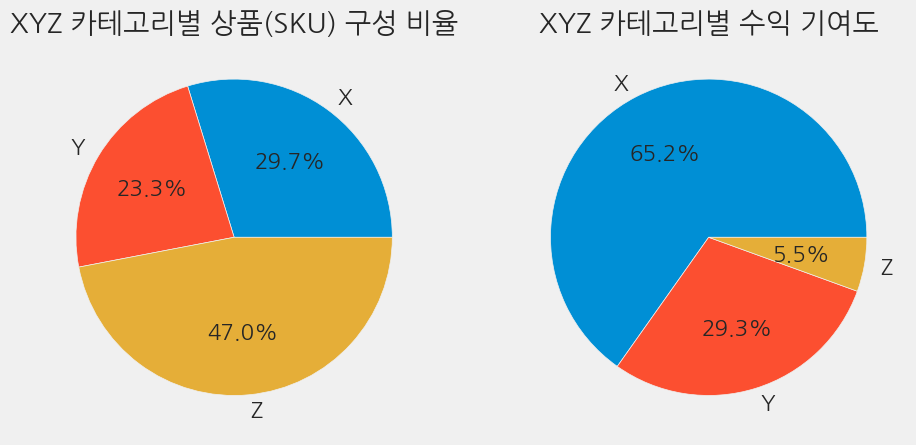

In [102]:
plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.pie(xyz_share.Perc, labels = ['X', 'Y', 'Z'], autopct='%1.1f%%', textprops={'fontsize': 16})
plt.title('XYZ 카테고리별 상품(SKU) 구성 비율')
plt.subplot(1,2,2)
plt.pie(profit_share.Perc, labels = ['X', 'Y', 'Z'], autopct = '%1.1f%%', textprops={'fontsize': 16})
plt.title('XYZ 카테고리별 수익 기여도')

In [103]:
#대시보드상 KPI 값 반영 
def _kpi_card(ax, title, value, subtitle=None):
    ax.set_axis_off()
    # Rounded rectangle "card"
    card = FancyBboxPatch(
        (0, 0), 1, 1,
        boxstyle="round,pad=0.02,rounding_size=0.04",
        linewidth=1,
        facecolor="lightskyblue", edgecolor="black")
    
    ax.add_patch(card)

    ax.text(0.04, 0.88, title, fontsize=15, fontweight="bold", va="top")
    ax.text(0.05, 0.45, value, fontsize=22, fontweight="bold", va="center")
    if subtitle:
        ax.text(0.05, 0.18, subtitle, fontsize=12, va="center")

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

def build_simple_dashboard(summary_table: pd.DataFrame, dead_stock_grouped: pd.DataFrame | None = None):
    df = summary_table.copy()

    # --- Basic sanity
    for col in ["Profit", "onHand"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # --- KPIs
    total_sku = len(df)
    # print(total_sku)
    a_share = (df["ABC_category"].eq("A").mean() * 100) if "ABC_category" in df else np.nan
    # print(a_share)

    profit_total = df.loc[df["profit_flag"].eq("Profit"), "Profit"].sum() if "profit_flag" in df else df["Profit"].sum()
    profit_a = df.loc[(df["ABC_category"].eq("A")) & (df["profit_flag"].eq("Profit")), "Profit"].sum() \
        if {"ABC_category","profit_flag"}.issubset(df.columns) else np.nan
    a_profit_share = (profit_a / profit_total * 100) if profit_total and not np.isnan(profit_a) else np.nan

    loss_share = (df["profit_flag"].eq("Loss").mean() * 100) if "profit_flag" in df else np.nan

    dead_cnt = len(dead_stock_grouped) if dead_stock_grouped is not None else 0
    dead_onhand = pd.to_numeric(dead_stock_grouped["onHand"], errors="coerce").sum() if (dead_stock_grouped is not None and "onHand" in dead_stock_grouped) else np.nan

    # Example "risk onHand": Loss + (C & Z)  (adjust to your logic)
    risk_mask = pd.Series(False, index=df.index)
    if {"profit_flag"}.issubset(df.columns):
        risk_mask |= df["profit_flag"].eq("Loss")
    if {"ABC_category","XYZ_Category"}.issubset(df.columns):
        risk_mask |= (df["ABC_category"].eq("C") & df["XYZ_Category"].eq("Z"))
    risk_onhand = df.loc[risk_mask, "onHand"].sum() if "onHand" in df.columns else np.nan


    # sns.set_style("whitegrid")
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(nrows=3, ncols=6, height_ratios=[1.0, 2.0, 2.0], hspace=0.55, wspace=0.35)

    # KPI 
    kpis = [
        ("총 상품", f"{total_sku:,}", None),
        ("% A 카테고리", f"{a_share:.1f}%" if not np.isnan(a_share) else "—", "SKU 비율"),
        ("A 카테고리 수익 비율", f"{a_profit_share:.1f}%" if not np.isnan(a_profit_share) else "—", "수익 비율"),
        ("적자 상품 %", f"{loss_share:.1f}%" if not np.isnan(loss_share) else "—", "SKU 비율"),
        ("Dead Stock", f"{dead_cnt:,}", "1년 동안 판매 없음"),
        ("CZ + 적자상품 재고", f"{risk_onhand:,.0f}" if not np.isnan(risk_onhand) else "—", "Loss + C&Z"),
    ]
    # print(kpis)

    for i, (t, v, s) in enumerate(kpis):
        ax = fig.add_subplot(gs[0, i])
        _kpi_card(ax, t, v, s)

    # --- Plot 1: ABC SKU share
    ax1 = fig.add_subplot(gs[1, 0:2])
    abc_counts = df["ABC_category"].value_counts(normalize=True).reindex(["A","B","C"]) * 100
    sns.barplot(x=abc_counts.index, y=abc_counts.values, ax=ax1, color="deepskyblue")
    ax1.set_title("ABC: 총 SKU")
    ax1.set_xlabel("")
    ax1.set_ylabel("SKY 비율")

    # --- Plot 2: ABC profit share (positive profit only)
    ax2 = fig.add_subplot(gs[1, 2:4])
    profit_pos = df[df["profit_flag"].eq("Profit")] if "profit_flag" in df else df.copy()
    abc_profit = profit_pos.groupby("ABC_category")["Profit"].sum().reindex(["A","B","C"])
    abc_profit_share = (abc_profit / abc_profit.sum() * 100)
    sns.barplot(x=abc_profit_share.index, y=abc_profit_share.values, ax=ax2, color="deepskyblue")
    ax2.set_title("ABC: 수익 비율 (%)")
    ax2.set_xlabel("")
    ax2.set_ylabel("수익의 비율")

    # --- Plot 3: XYZ SKU share
    ax3 = fig.add_subplot(gs[1, 4:6])
    xyz_counts = df["XYZ_Category"].value_counts(normalize=True).reindex(["X","Y","Z"]) * 100
    sns.barplot(x=xyz_counts.index, y=xyz_counts.values, ax=ax3, color="deepskyblue")
    ax3.set_title("XYZ: 총 SKU 비율 (%)")
    ax3.set_xlabel("")
    ax3.set_ylabel("SKU 비율")

    # --- Plot 4: onHand by segment (ABC×XYZ)
    ax4 = fig.add_subplot(gs[2, 3:6])
    if {"ABC_category","XYZ_Category","onHand"}.issubset(df.columns):
        tmp = (df.groupby(["ABC_category","XYZ_Category"])["onHand"]
                 .sum()
                 .reset_index())
        # create combined label
        tmp["segment"] = tmp["ABC_category"] + "-" + tmp["XYZ_Category"]
        # order segments
        order = [f"{a}-{x}" for a in ["A","B","C"] for x in ["X","Y","Z"]]
        tmp = tmp.set_index("segment").reindex(order).reset_index()

        sns.barplot(data=tmp, x="segment", y="onHand", ax=ax4, color="lightskyblue")
        ax4.set_title("ABC-XYZ 카테고리별 재고 현황")
        ax4.set_xlabel("")
        ax4.set_ylabel("재고")
        ax4.tick_params(axis="x", rotation=45)
    else:
        ax4.text(0.5, 0.5, "onHand / ABC / XYZ columns missing", ha="center", va="center")
        ax4.set_axis_off()

    # --- Plot 5: Dead stock (top 10 by onHand)
    ax5 = fig.add_subplot(gs[2, 0:3])
    if dead_stock_grouped is not None and {"Description","onHand"}.issubset(dead_stock_grouped.columns):
        dead_top = dead_stock_grouped.copy()
        dead_top["onHand"] = pd.to_numeric(dead_top["onHand"], errors="coerce")
        dead_top = dead_top.sort_values("onHand", ascending=False).head(10)
        sns.barplot(data=dead_top, y="Description", x="onHand", ax=ax5, color="lightskyblue")
        ax5.set_xlabel("재고")
        ax5.set_ylabel("")
        ax5.set_yticklabels([])
        ax5.set_title("Dead Stock 현황")

        for p, label in zip(ax5.patches, dead_top["Description"]):
            ax5.text(p.get_width()*0.02, p.get_y() + p.get_height()/2,
                     label, va = "center", ha = "left", color = "black",
                     fontsize = 11,
                     fontweight = "bold")
    else:
        subtitle = f"Dead SKUs: {dead_cnt:,}"
        if not np.isnan(dead_onhand):
            subtitle += f"\nDead onHand: {dead_onhand:,.0f}"
        ax5.text(0.5, 0.5, subtitle, ha="center", va="center")
        ax5.set_axis_off()

    fig.suptitle("재고 분석 대시보드 (ABC–XYZ–Profit–Dead Stock)", fontsize=20, fontweight="bold", y=0.98)
    plt.show()

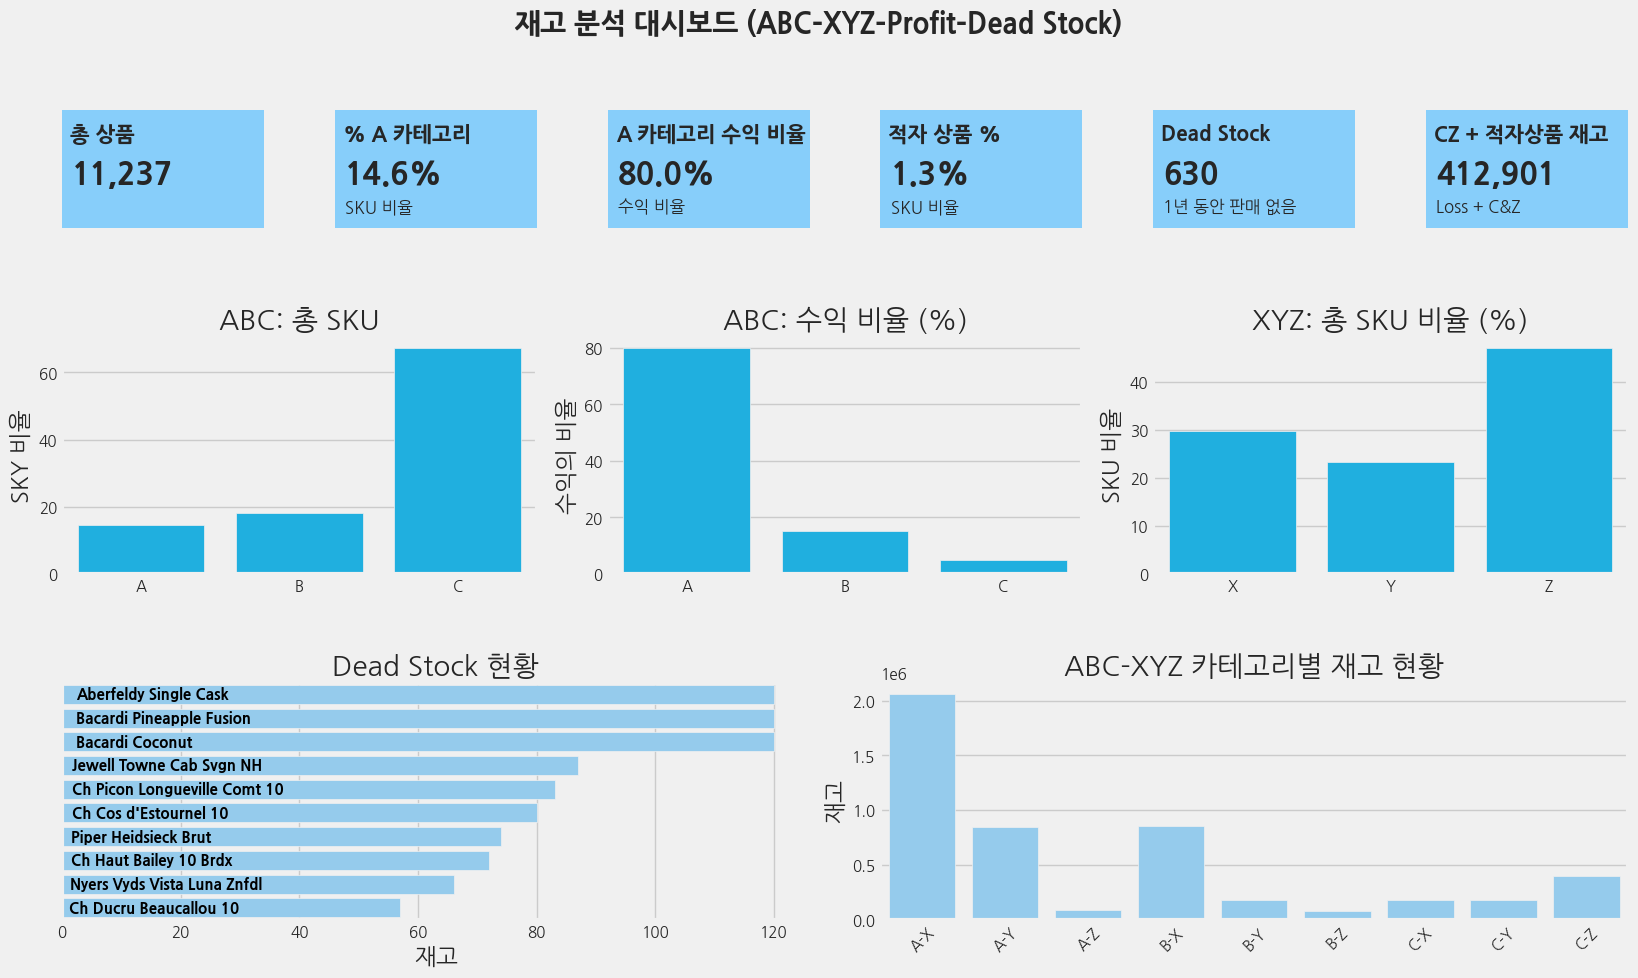

In [104]:
build_simple_dashboard(summary_table, dead_stock_grouped)

A 카테고리 상품은 전체 SKU의 14.6%에 불과하지만 전체 수익의 약 80%를 창출하는 것으로 나타났습니다.    
특히 A 카테고리 중 X 카테고리에 속한 상품들은 수요가 안정적이어서 매출 예측이 가능하며,     
지속적인 재고 관리 및 높은 서비스 레벨 유지가 필요한 핵심 상품군으로 판단됩니다.     
     
반면 전체 상품의 60% 이상은 C 카테고리에 속해 있으며,     
해당 상품군의 수익 기여도는 전체의 5% 미만으로 매우 낮은 수준입니다.     
이는 다수의 상품이 매출 및 수익 측면에서 제한적인 가치를 가지고 있음을 의미합니다.    

또한 최근 1년간 판매 실적이 전혀 없는 상품이 총 630개로 확인되어,    
해당 상품들은 Dead Stock으로 분류하였습니다.    
이는 재고 회전율 저하 및 보관 비용 증가의 주요 원인으로 작용할 수 있습니다.    
     
현재 보유 재고를 ABC–XYZ 기준으로 분석한 결과,     
A–X 카테고리 상품의 재고 비중이 가장 높아 핵심 상품에 대한 재고 집중 현상은 긍정적으로 평가됩니다.     
그러나 동시에 C–Z 카테고리에 속하거나 적자를 기록한 상품의 재고가 총 412,901개에 달해,       
수요 변동성이 높고 수익성이 낮은 재고에 상당한 자원이 묶여 있는 것으로 나타났습니다.    
     
이를 종합적으로 고려할 때,    
A–X 상품은 보호 및 우선 관리 대상(Protect)으로 유지하되,    
C–Z 및 적자 상품에 대해서는 재고 축소, 판매 전략 재검토 또는 단계적 단종을 포함한    
적극적인 재고 구조 개선 전략이 필요하다고 판단됩니다.    


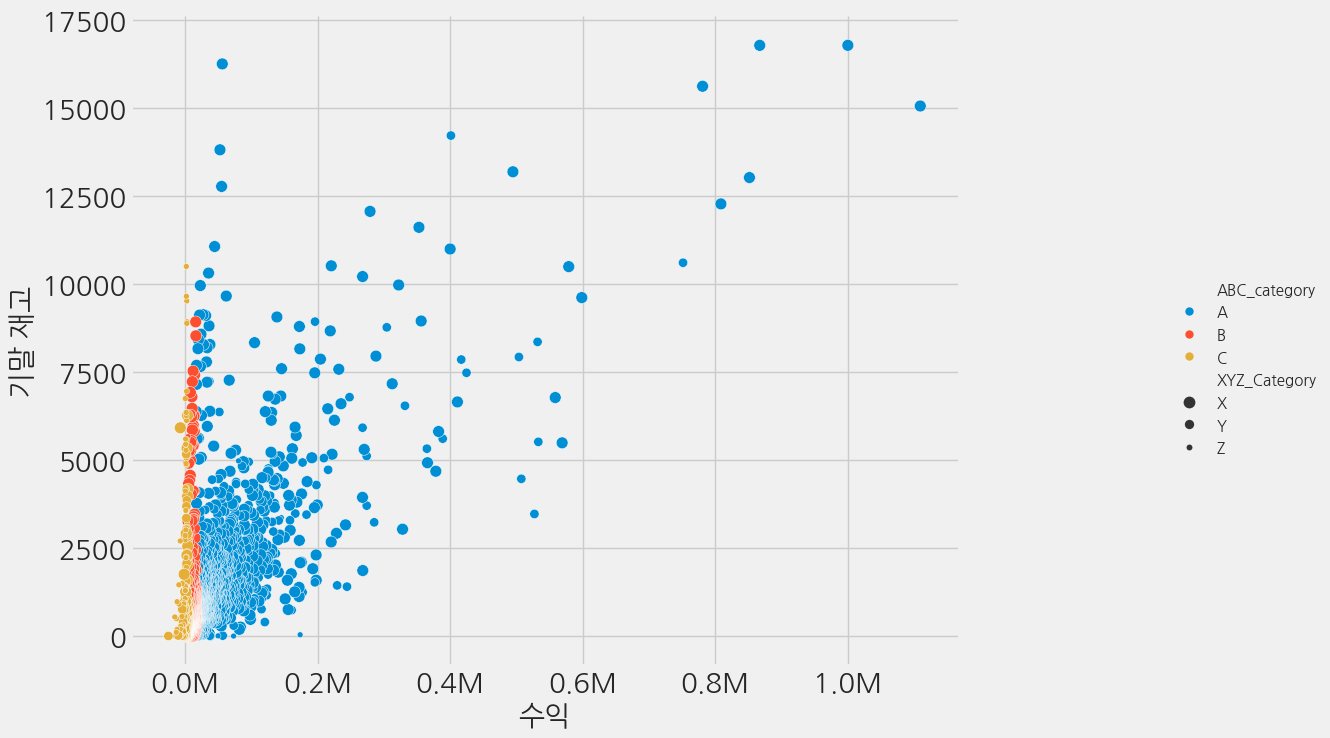

In [105]:
g = sns.relplot(
    data=summary_table,
    x="Profit", y="onHand",
    hue="ABC_category", size="XYZ_Category",)

plt.ylabel('기말 재고', fontsize=20 )
plt.xlabel('수익', fontsize=20)
plt.tick_params(axis='both', labelsize=20)

ax = g.ax  
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x*1e-6:.1f}M'.format(x))) 


g.figure.set_size_inches(15, 8)

> 수익이 높은 제품들은 모두 A 카테고리에 속하며,    
> 재고량이 많은 제품 중 일부는 C·Z 카테고리의 상품들이 있습니다

In [106]:
summary_table[
    (summary_table['ABC_category'] =='C') &(summary_table['XYZ_Category'] =='Z') & (summary_table['onHand'] > 5000)]\
    .sort_values(by = 'onHand', ascending = False)

,Brand,Description,SalesQuantity,NetSales,Profit,margin_pct,profit_flag,abc_scope,ABC_category,XYZ_Category,onHand
4908,3581,Pinnacle Citrus,9188,"8,620.39","1,821.27",0.21,Profit,Pareto_scope,C,Z,"10,493.00"
4834,3594,Pinnacle Tropical Punch,11443,"10,734.51","1,923.40",0.18,Profit,Pareto_scope,C,Z,"9,646.00"
4406,3566,Pinnacle Raspberry,11128,"10,439.27","2,538.39",0.24,Profit,Pareto_scope,C,Z,"9,514.00"
4244,3638,Pinnacle Whipped,14844,"13,921.91","2,788.91",0.20,Profit,Pareto_scope,C,Z,"8,921.00"
4362,3454,Pinnacle Pineapple,11940,"11,199.70","2,602.90",0.23,Profit,Pareto_scope,C,Z,"8,876.00"
4610,2107,Rebel Yell Ginger Bourbon,11208,"10,513.92","2,220.00",0.21,Profit,Pareto_scope,C,Z,"6,950.00"
7968,5609,Integre Vodka,430,"2,237.26",224.86,0.10,Profit,Pareto_scope,C,Z,"6,741.00"
5115,7956,Bayou Satsuma Rum Liqueur,10626,"9,970.23","1,575.69",0.16,Profit,Pareto_scope,C,Z,"6,347.00"
5054,7948,Bayou Silver Rum,7898,"7,411.30","1,645.76",0.22,Profit,Pareto_scope,C,Z,"6,259.00"
4570,7936,Bayou Spiced Rum,9943,"9,328.98","2,269.45",0.24,Profit,Pareto_scope,C,Z,"6,121.00"


> 상기 제품은 수익 기여도가 낮고 수요 변동성이 커 예측이 어렵지만, 현재 재고가 매우 높은 수준입니다.  
> 매장별 재고 및 판매 현황을 확인할 필요가 있습니다.

In [107]:
summary_table['ABC_XYZ_category'] = summary_table['ABC_category'] + summary_table['XYZ_Category']

Text(0.5, 0, '')

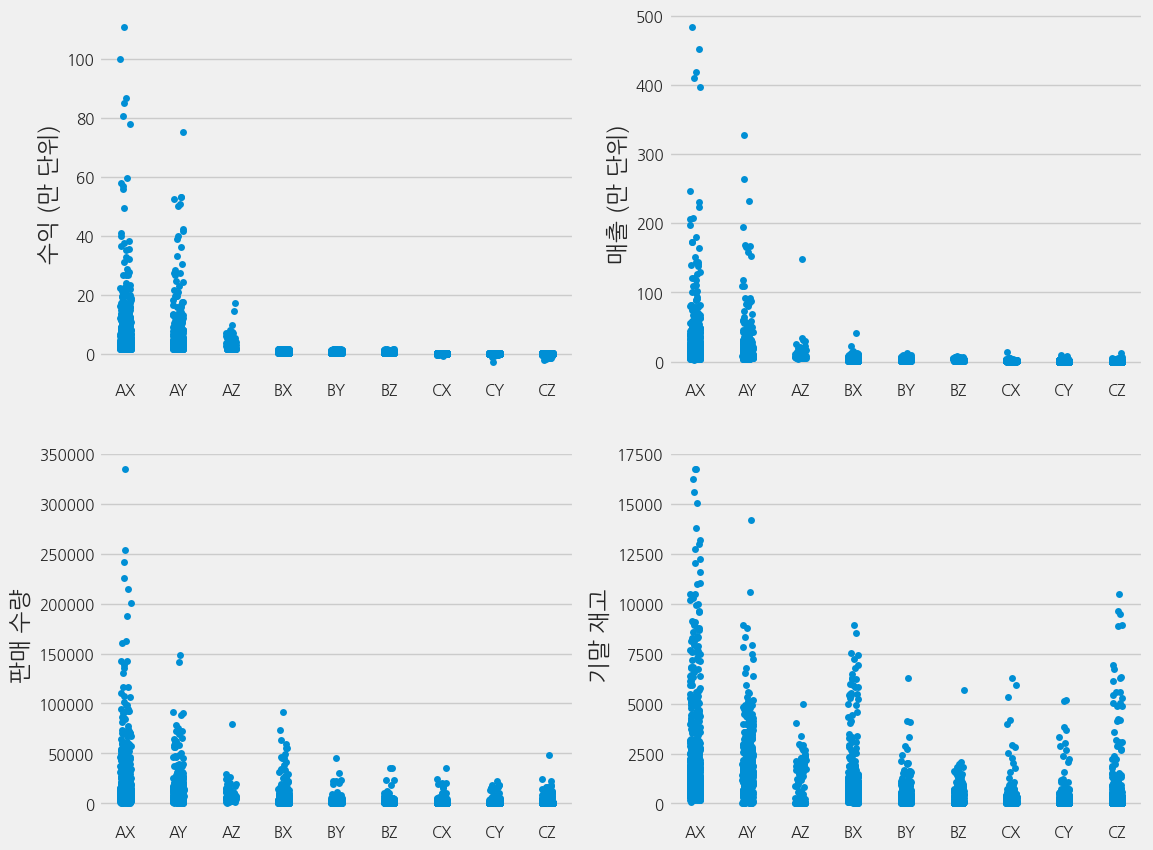

In [108]:
fig, axs = plt.subplots(2,2, figsize = (12,10))

order = ['AX', 'AY', 'AZ', 'BX', 'BY', 'BZ', 'CX', 'CY', 'CZ']
sns.stripplot(x  = summary_table.ABC_XYZ_category, y = summary_table.Profit/10000, jitter = True, ax = axs[0,0], order=order)
axs[0,0].set_ylabel("수익 (만 단위)")
axs[0,0].set_xlabel("")
sns.stripplot(x  = summary_table.ABC_XYZ_category, y = summary_table.NetSales/10000, jitter = True, ax = axs[0,1], order=order)
axs[0,1].set_ylabel("매출 (만 단위)")
axs[0,1].set_xlabel("")
sns.stripplot(x  = summary_table.ABC_XYZ_category, y = summary_table.SalesQuantity, jitter = True, ax = axs[1,0], order=order)
axs[1,0].set_ylabel("판매 수량")
axs[1,0].set_xlabel("")
sns.stripplot(x  = summary_table.ABC_XYZ_category, y = summary_table.onHand, jitter = True, ax = axs[1,1], order=order)
axs[1,1].set_ylabel("기말 재고")
axs[1,1].set_xlabel("")


In [109]:
summary_table

,Brand,Description,SalesQuantity,NetSales,Profit,margin_pct,profit_flag,abc_scope,ABC_category,XYZ_Category,onHand,ABC_XYZ_category
0,1233,Jack Daniels No 7 Black,142049,"4,840,920.31","1,109,293.08",0.23,Profit,Pareto_scope,A,X,"15,047.00",AX
1,3545,Ketel One Vodka,135838,"3,973,519.79","1,000,025.97",0.25,Profit,Pareto_scope,A,X,"16,770.00",AX
2,4261,Capt Morgan Spiced Rum,200412,"4,107,730.08","867,068.04",0.21,Profit,Pareto_scope,A,X,"16,769.00",AX
3,6570,Kendall Jackson Chard Vt RSV,214238,"2,301,924.01","851,532.75",0.37,Profit,Pareto_scope,A,X,"13,016.00",AX
4,3405,Tito's Handmade Vodka,160247,"4,524,634.83","808,506.90",0.18,Profit,Pareto_scope,A,X,"12,268.00",AX
...,...,...,...,...,...,...,...,...,...,...,...,...
11232,10666,Clayhouse Adobe Cntrl Cst Wh,5636,"30,556.40","-13,066.24",-0.43,Loss,Excluded_from_Pareto,C,Z,491.00,CZ
11233,33331,Moletto Prosecco Della Marc,7236,"64,254.63","-13,387.65",-0.21,Loss,Excluded_from_Pareto,C,Z,107.00,CZ
11234,44714,Buehler Znfdl Napa,9925,"118,508.31","-15,578.44",-0.13,Loss,Excluded_from_Pareto,C,Z,542.00,CZ
11235,26710,Feudi Di San Gregorio Fiano,4995,"25,471.13","-20,782.57",-0.82,Loss,Excluded_from_Pareto,C,Z,0.00,CZ


In [110]:
category_summary = summary_table.groupby('ABC_XYZ_category').agg(
    NumberOfItems=('ABC_XYZ_category', 'count'),
    SalesQuantity=('SalesQuantity', 'sum'),
    Profit=('Profit', 'sum'),
    NetSales=('NetSales', 'sum'),
    CurrentStock=('onHand', 'sum')
)
category_summary['ItemShare'] = category_summary['NumberOfItems']/category_summary['NumberOfItems'].sum().round(2)
category_summary['SalesQuantityShare'] = category_summary['SalesQuantity']/category_summary['SalesQuantity'].sum().round(2)
category_summary['ProfitShare'] = category_summary['Profit']/category_summary['Profit'].sum().round(2)
category_summary['NetSalesShare'] = category_summary['NetSales']/category_summary['NetSales'].sum().round(2)
category_summary['StockShare'] = category_summary['CurrentStock']/category_summary['CurrentStock'].sum().round(2)

In [111]:
category_summary

,NumberOfItems,SalesQuantity,Profit,NetSales,CurrentStock,ItemShare,SalesQuantityShare,ProfitShare,NetSalesShare,StockShare
ABC_XYZ_category,,,,,,,,,,
AX,1124,17253726,"63,532,349.12","242,022,849.11","2,061,325.00",0.10,0.52,0.53,0.56,0.42
AY,442,6103478,"29,559,511.08","91,796,021.76","841,726.00",0.04,0.19,0.25,0.21,0.17
AZ,79,717033,"2,876,683.79","9,780,348.08","91,145.00",0.01,0.02,0.02,0.02,0.02
BX,1381,4654155,"12,708,200.82","45,953,190.69","854,529.00",0.12,0.14,0.11,0.11,0.18
BY,415,917521,"3,462,476.51","12,076,214.85","181,731.00",0.04,0.03,0.03,0.03,0.04
BZ,238,576942,"1,835,699.71","6,414,497.57","80,199.00",0.02,0.02,0.02,0.01,0.02
CX,838,792107,"1,761,105.60","6,536,520.01","182,793.00",0.07,0.02,0.01,0.02,0.04
CY,1758,770810,"1,984,118.05","8,764,819.90","182,103.00",0.16,0.02,0.02,0.02,0.04
CZ,4962,1131981,"1,917,885.84","9,744,341.00","397,354.00",0.44,0.03,0.02,0.02,0.08


ABC 및 XYZ 카테고리 바탕으로 decision matrix을 생성하여 아래와 같은 카테고리로 모든 상품을 분리합니다    

__Protect (high SL)__      
수익 기여도가 높고 수요가 안정적인 핵심 상품으로, 높은 서비스 레벨과 안정적인 재고 확보가 필요합니다.    

__Protect + Monitor__      
중요한 상품이지만 수요 변동성이 존재하므로 지속적인 모니터링과 예측 정확도 관리가 필요합니다.    

__Protect + Risk buffer__       
수익 기여도는 높으나 수요 변동성이 커, 재고 버퍼 및 리스크 관리 중심의 운영이 요구됩니다.

__Efficient replenish__       
비교적 안정적인 수요를 가진 중간 중요도 상품으로, 효율적인 보충 정책을 통해 비용을 최소화해야 합니다.

__Optimize MOQ/ROP__      
수요 변동성이 존재하는 상품으로, 최소 주문 수량(MOQ) 및 재주문 시점(ROP)의 최적화가 필요합니다.

__Limited stock__        
수요 예측이 어려운 상품으로, 재고를 제한적으로 운영하여 과잉 재고 리스크를 줄여야 합니다.

__Rationalize assortment__        
수익 기여도가 낮은 상품군으로, 상품 구성 단순화 및 라인업 정리가 필요합니다.

__Automate (low-touch)__       
관리 우선순위가 낮은 상품으로, 자동 발주 등 최소 관리 방식으로 운영하는 것이 적절합니다.

__Make-to-order__         
수요가 불규칙한 상품으로, 주문 발생 시 생산 또는 입고하는 방식이 적합합니다.

__Discontinue candidate__        
수익성과 수요 모두 낮아 단계적 단종 또는 취급 중단 검토가 필요한 상품입니다.

__Fix pricing/sourcing__        
수요는 안정적이나 가격 구조 문제로 손실이 발생하고 있어, 가격 조정 또는 공급 조건 개선이 필요합니다.

In [112]:
def assign_decision(row):
    abc = row.get("ABC_category")
    xyz = row.get("XYZ_Category")
    pf  = row.get("profit_flag")

    
    if pf == "Loss":
        # 수요가 안정적이지만 수익이 없는 상품
        if xyz == "X":
            return "Fix pricing/sourcing"
        return "Discontinue candidate"

    # Profit
    if abc == "A":
        if xyz == "X":
            return "Protect (high SL)"
        if xyz == "Y":
            return "Protect + Monitor"
        if xyz == "Z":
            return "Protect + Risk buffer"

    if abc == "B":
        if xyz == "X":
            return "Efficient replenish"
        if xyz == "Y":
            return "Optimize MOQ/ROP"
        if xyz == "Z":
            return "Limited stock"

    if abc == "C":
        if xyz == "X":
            return "Automate (low-touch)"
        if xyz == "Y":
            return "Rationalize assortment"
        if xyz == "Z":
            return "Make-to-order"

    return "Review"

In [113]:
def build_decision_table(df):
    df = df.copy()

    # numeric safety
    df["Profit"]  = pd.to_numeric(df["Profit"], errors="coerce")
    df["onHand"]  = pd.to_numeric(df["onHand"], errors="coerce")
    df["margin_pct"] = pd.to_numeric(df.get("margin_pct"), errors="coerce")

    # decision label
    df["decision"] = df.apply(assign_decision, axis=1)

    # segment table (ABC×XYZ)
    seg = (
        df.groupby(["ABC_category", "XYZ_Category"])
          .agg(
              sku_count=("Brand", "count"),
              profit_sum=("Profit", "sum"),
              onhand_sum=("onHand", "sum"),
              loss_skus=("profit_flag", lambda s: (s=="Loss").sum()),
              avg_margin=("margin_pct", "mean"),
          )
          .reset_index()
    )
    seg["loss_share"] = seg["loss_skus"] / seg["sku_count"]
    return df, seg

In [114]:
def plot_decision_heatmap_ax(ax, seg, metric="sku_count", fmt=None, title=None):
    pivot = seg.pivot(index="ABC_category", columns="XYZ_Category", values=metric)
    pivot = pivot.reindex(index=["A", "B", "C"], columns=["X", "Y", "Z"]).fillna(0)

    if fmt is None:
        fmt = ".0f" if metric in ["sku_count", "onhand_sum", "profit_sum"] else ".1%"

    if title is None:
        title = f"ABC × XYZ: {metric}"

    sns.heatmap(
        pivot,
        annot=True,
        fmt=fmt,
        linewidths=0.6,
        cbar=True,
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel("XYZ")
    ax.set_ylabel("ABC")

,ABC_category,XYZ_Category,sku_count,profit_sum,onhand_sum,loss_skus,avg_margin,loss_share
0,A,X,1124,"63,532,349.12","2,061,325.00",0,0.30,0.00
1,A,Y,442,"29,559,511.08","841,726.00",0,0.35,0.00
2,A,Z,79,"2,876,683.79","91,145.00",0,0.33,0.00
3,B,X,1381,"12,708,200.82","854,529.00",0,0.31,0.00
4,B,Y,415,"3,462,476.51","181,731.00",0,0.31,0.00
5,B,Z,238,"1,835,699.71","80,199.00",0,0.31,0.00
6,C,X,838,"1,761,105.60","182,793.00",10,0.30,0.01
7,C,Y,1758,"1,984,118.05","182,103.00",31,0.30,0.02
8,C,Z,4962,"1,917,885.84","397,354.00",101,0.30,0.02


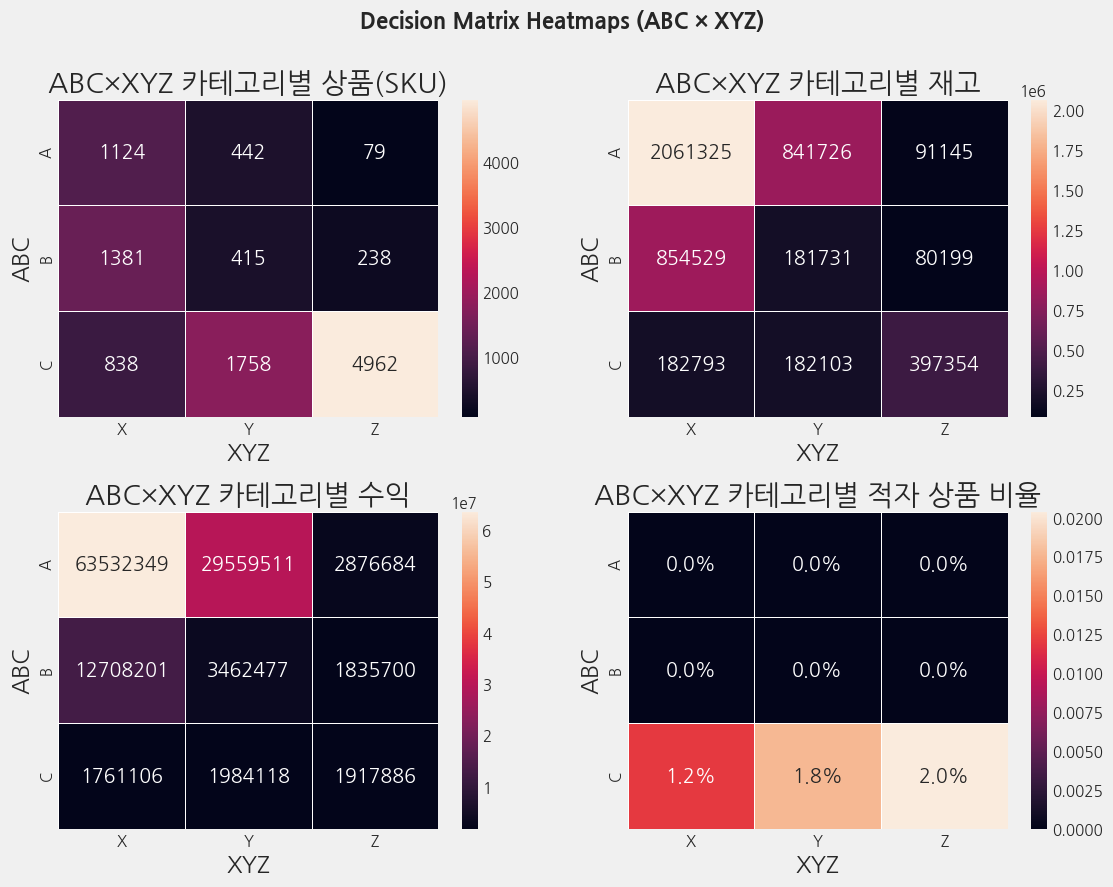

In [115]:
df_labeled, seg = build_decision_table(summary_table)

display(seg.sort_values(["ABC_category","XYZ_Category"]))

fig, axs = plt.subplots(2, 2, figsize=(12, 9))
plt.subplots_adjust(hspace=0.30, wspace=0.20)

plot_decision_heatmap_ax(axs[0, 0], seg, metric="sku_count",
                         title="ABC×XYZ 카테고리별 상품(SKU)")

plot_decision_heatmap_ax(axs[0, 1], seg, metric="onhand_sum",
                         title="ABC×XYZ 카테고리별 재고")

plot_decision_heatmap_ax(axs[1, 0], seg, metric="profit_sum",
                         title="ABC×XYZ 카테고리별 수익")

plot_decision_heatmap_ax(axs[1, 1], seg, metric="loss_share", fmt=".1%",
                         title="ABC×XYZ 카테고리별 적자 상품 비율")

fig.suptitle("Decision Matrix Heatmaps (ABC × XYZ)", fontsize=16, fontweight="bold", y=0.98)
plt.show()

적자 상품 중 X 카테고리에 속한 상품들은 수요가 비교적 안정적임에도 불구하고    
마진이 낮아 지속적으로 마이너스 수익을 기록하고 있습니다.     
이는 수요 문제가 아닌 가격 구조 또는 구매 조건에 기인한 손실로 판단되며,     
해당 상품군에 대해서는 공급자 변경, 구매가 재협상 또는 판매가 조정과 같은       
가격 및 조달 전략의 재검토가 필요합니다     

In [116]:
df_labeled[df_labeled['decision']=='Fix pricing/sourcing']

,Brand,Description,SalesQuantity,NetSales,Profit,margin_pct,profit_flag,abc_scope,ABC_category,XYZ_Category,onHand,ABC_XYZ_category,decision
11123,272,Juarez Silver Tequila,1059,"7,689.96",-146.64,-0.02,Loss,Excluded_from_Pareto,C,X,106.00,CX,Fix pricing/sourcing
11141,269,Juarez Triple Sec,1693,"4,977.42",-389.39,-0.08,Loss,Excluded_from_Pareto,C,X,126.00,CX,Fix pricing/sourcing
11147,8446,Richards Wild Irish Rose Red,2204,"9,734.34",-492.22,-0.05,Loss,Excluded_from_Pareto,C,X,263.00,CX,Fix pricing/sourcing
11163,541,Juarez Gold Tequila,1337,"9,600.28",-828.32,-0.09,Loss,Excluded_from_Pareto,C,X,48.00,CX,Fix pricing/sourcing
11167,4326,Rumson's Coffee Rum,732,"15,446.85",-935.31,-0.06,Loss,Excluded_from_Pareto,C,X,139.00,CX,Fix pricing/sourcing
11174,658,Allens Triple Sec,4237,"8,219.78","-1,101.62",-0.13,Loss,Excluded_from_Pareto,C,X,168.00,CX,Fix pricing/sourcing
11181,3452,Vanya Light Vodka,24803,"136,226.20","-1,430.45",-0.01,Loss,Excluded_from_Pareto,C,X,"1,754.00",CX,Fix pricing/sourcing
11184,4422,Jenkins Spiced Rum,4752,"39,169.36","-1,555.28",-0.04,Loss,Excluded_from_Pareto,C,X,529.00,CX,Fix pricing/sourcing
11191,7680,Viniq Shimmery Glow,1104,"19,706.45","-2,020.27",-0.10,Loss,Excluded_from_Pareto,C,X,233.00,CX,Fix pricing/sourcing
11223,5270,Southern Comfort,35269,"47,452.90","-7,214.05",-0.15,Loss,Excluded_from_Pareto,C,X,"5,913.00",CX,Fix pricing/sourcing


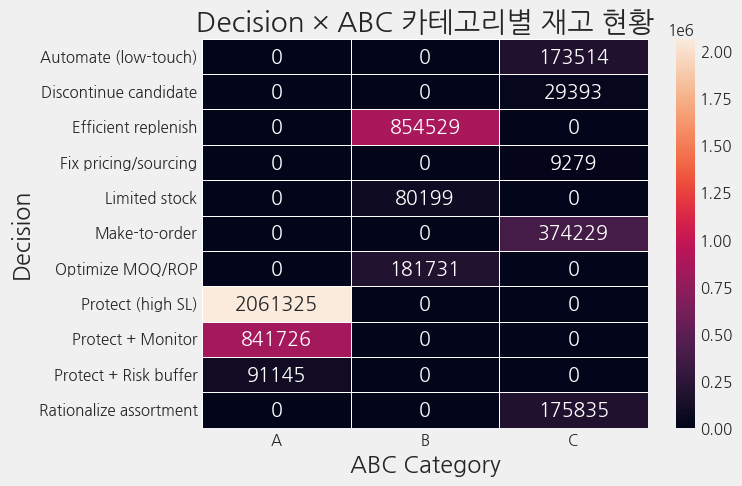

In [117]:
decision_abc = (
    df_labeled
    .groupby(['decision', 'ABC_category'])['onHand']
    .sum()
    .reset_index()
)

pivot_decision_abc = decision_abc.pivot(
    index='decision',
    columns='ABC_category',
    values='onHand'
).fillna(0)

sns.heatmap(
    pivot_decision_abc,
    annot=True,
    fmt=".0f",
    linewidths=0.6,
    cbar=True
)

plt.title("Decision × ABC 카테고리별 재고 현황")
plt.xlabel("ABC Category")
plt.ylabel("Decision")
plt.show()

In [118]:
df_labeled['decision'].unique()

array(['Protect (high SL)', 'Protect + Monitor', 'Protect + Risk buffer',
       'Efficient replenish', 'Optimize MOQ/ROP', 'Limited stock',
       'Rationalize assortment', 'Automate (low-touch)', 'Make-to-order',
       'Discontinue candidate', 'Fix pricing/sourcing'], dtype=object)